# Demo: Herramienta de evaluación de campos

In [154]:
import pandas as pd
import numpy as np
from datetime import datetime
import dateparser 
import matplotlib.pyplot as plt

import seaborn as sns

import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize

from datetime import datetime, timedelta,date
%matplotlib inline

import cashflows as cf

import timeit
import warnings

In [164]:
plt.style.use('seaborn-white')

pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 18})

sns.set_context("paper", font_scale=2.5)  

# Full Script

In [243]:
#########################################                            ########################################




########################################          PRODUCTIVIDAD     #########################################




########################################                            #########################################






##################    CARGA DE BASE DE DATOS DE CNH   ######################

def carga_bd():
    
    global mx_bd
    global mx_reservas
    
    tic=timeit.default_timer()
    
    mx_bd=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/mexico/mx_full.csv',
                          usecols=['fecha',
                                  'pozo',
                                  'aceite_Mbd',
                                  'gas_asociado_MMpcd',
                                  'gas_no_asociado_MMpcd',
                                  'condensado_Mbd',
                                  'agua_Mbd',
                                  'estado_actual',
                                  'profundidad_total',
                                  'profundidad_vertical',
                                  'trayectoria', 
                                  'ano_de_perforacion',
                                  'tipo_de_hidrocarburo',
                                  'clasificacion',
                                  'disponible',
                                  'campo',
                                  'cuenca', 
                                  'entidad',  
                                  'ubicacion',
                                  'contrato'],
                                  low_memory=True)
            
    mx_reservas=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/mexico/mx_reservas.csv',
                          index_col=0)
    
    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')


##################    FUNCIÓN DE PRODUCTIVIDAD   ######################

def productividad():
    
    global perfil
    global df
    global tipo1
    global tipo2
    global tipo3
    global ajuste
    global tipos
    
    tic=timeit.default_timer()
    
    global alta, media, baja
    
    alta=0.90
    media=0.50
    baja=0.30
    
##################    INPUT CAMPO   ######################
    
    #input de campo de analisis
    def campo_analisis():
        
        global input_campo, input_hidrocarburo, input_fecha
        global pozos
        global len_proy
        global nequip
        global cap
        global reservas_aceite, info_reservas
        global num_pozos
        global pozos_tipo1,pozos_tipo2,pozos_tipo3
        global regimen_fiscal, regalia_adicional, region_fiscal
        global lista_pozos
        
        #SECCION DE INPUTS
        
        #INPUT DE CAMPO
        input_campo = str(input("Nombre de campo: "))
        
        #INPUT DE RANGO DE MUESTRA
        input_fecha=input("Tomar muestra desde fecha (yyyy-mm-dd): ")

        if input_fecha == str(''):
            input_fecha='2000-01-01'
            
        input_fecha=pd.Timestamp(input_fecha)
        
        #INPUTS ECONOMICOS
        
        #Regimen Fiscal especificar si es "licencia", "cpc" o "asignacion" 
        regimen_fiscal = input("Régimen Fiscal: ") #"licencia"
        regimen_fiscal = str(regimen_fiscal)
        if regimen_fiscal not in ["licencia","cpc","asignacion"]:
             raise SystemExit("Párametro Inválido")


        if regimen_fiscal == "licencia":
            regalia_adicional = input("Regalía Adicional Decimales: ") #En decimales el porcentaje de regalía adicional para los contratos de licencia
            regalia_adicional = float(regalia_adicional)

        #Region fiscal: aceite_terrestre, aguas_someras, aguas_profundas, gas, chicontepec 
        region_fiscal =  input("Región Fiscal: ") #"aceite_terrestre"   
        region_fiscal=str(region_fiscal)
        if region_fiscal not in ["aceite_terrestre","aguas_someras","aguas_profundas","gas","chicontepec"]:
            raise SystemExit("Párametro Inválido")
        
        
        #Subset de la BD con el campo de analisis

        seleccion_pozo=mx_bd.pozo.str.contains(pat=input_campo,regex=True)
        seleccion_campo=mx_bd.campo.str.contains(pat=input_campo,regex=True)
        pozos=mx_bd.loc[seleccion_campo & seleccion_pozo]
        
        seleccion_reservas=mx_reservas.NOMBRE.str.match(pat=input_campo)
        info_reservas=mx_reservas.loc[seleccion_reservas]
        #info_reservas=mx_reservas[mx_reservas.NOMBRE == str(input_campo)]
        
        lista_pozos=list(pd.unique(pozos['pozo']))

        display('Número de pozos en ' +str(input_campo)+': '+str(len(lista_pozos)))

        #Generacion de archivo de resultados
        #pozos.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))
        
        
        #INPUTS DE VARIABLES DE EVALUACION
        
        #duracion=int(input('Duracion del contrato (años): '))
        #nequip=input('Numero de equipos: ')
        #cap=input('Capacidad de procesamiento (Mbd: ')
        #reservas=input('Reservas: ')
        
        len_proy=0
        duracion=40
        len_proy=duracion*12
        num_pozos=6
        nequip=1
        cap=1_000
        reservas_aceite=float(info_reservas['CRUDO 2P (MMB)'])
        reservas_gas=float(info_reservas['GAS NATURAL 2P (MMBPCE)'])
        
        pozos_tipo1=np.round(num_pozos*baja,0)
        pozos_tipo2=np.round(num_pozos*media,0)
        pozos_tipo3=num_pozos-(pozos_tipo1+pozos_tipo2)

        return len_proy, nequip, cap, reservas_aceite, num_pozos
    

########      FUNCIONES PARA EL ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
 
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):

        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hiperbolica(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponencial(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonica(t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot resultados
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    
#############     ANÁLISIS DE DECLINACION DE POZOS (DCA)   #############

    def analisis_dca():
        
        global resultados, resultados_desde
        global gasto, prod_base, Q_base, G_base, C_base
        global hidrocarburo, gas, condensado
        global unique_well_list
        global estadistica, acumulados, status
        
        resultados=pd.DataFrame()
        gasto=pd.DataFrame()
        Qi=pd.DataFrame()
        prod_base=pd.DataFrame()
        resultados_desde=pd.DataFrame()
        status=pd.DataFrame()
        
        #Entrada de campo de análisis
        campo_analisis()
        data_pozos=pozos
        
        #Limpieza de datos y formato de fecha
        data_pozos['fecha']=pd.to_datetime(data_pozos['fecha'])
        
        #Hidrocarburos de análisis
        if data_pozos.aceite_Mbd.sum() > data_pozos.gas_no_asociado_MMpcd.sum():
            
            hidrocarburo='aceite_Mbd'
            gas='gas_asociado_MMpcd'
            
        else:
            
            hidrocarburo='gas_no_asociado_MMpcd'
            gas='gas_no_asociado_MMpcd'
        
        condensado='condensado_Mbd'
        
        #Remove all rows with null values in the desired time series column
        data_pozos=remove_nan_and_zeroes_from_columns(data_pozos, hidrocarburo)
        
        #Get a list of unique wells to loop through
        unique_well_list=list(pd.unique(data_pozos.pozo))
        
        #Get the earliest RecordDate for each Well
        data_pozos['first_oil']= get_min_or_max_value_in_column_by_group(data_pozos, group_by_column='pozo', 
                                                                        calc_column='fecha', calc_type='min')
        #Generate column for time online delta
        data_pozos['days_online']=generate_time_delta_column(data_pozos, time_column='fecha', 
                      date_first_online_column='first_oil')
        
        #Generacion de dataframes por rangos de fechas de análisis
        data_pozos_range=data_pozos[(data_pozos.fecha>='1900-01-01') & (data_pozos.fecha<='2020-02-01')]
        pozos_desde=data_pozos[(data_pozos.first_oil>=input_fecha) & (data_pozos.first_oil<='2020-02-01')]
        
        #Loop para realizar el DCA en cada pozo del campo
        for pozo in unique_well_list:
            
            #Subset del data frame del campo por pozo
            serie_produccion=data_pozos_range[data_pozos_range.pozo==pozo]
            serie_produccion=serie_produccion.set_index('pozo')
            
            serie_desde=pozos_desde[pozos_desde.pozo==pozo]
            serie_desde=serie_desde.set_index('pozo')
            
            #Calculo de declinacion porcentual
            serie_produccion['declinacion']=serie_produccion[hidrocarburo].pct_change(periods=1)
            
            #Cálculo de la máxima producción inicial
            qi=get_max_initial_production(serie_produccion, 500, hidrocarburo, 'fecha')
            qi_g=get_max_initial_production(serie_produccion, 500, gas, 'fecha')
            qi_c=get_max_initial_production(serie_produccion, 500, condensado, 'fecha')

            if qi_g == 0:
                qi_g = 0.00000000000000000000000000000000000000000001
            
            if qi_c == 0:
                qi_c = 0.00000000000000000000000000000000000000000001
                
            qi_desde=get_max_initial_production(serie_desde, 500, hidrocarburo, 'fecha')
            qi_g_desde=get_max_initial_production(serie_desde, 500, gas, 'fecha')
            qi_c_desde=get_max_initial_production(serie_desde, 500, condensado, 'fecha')

            if qi_g_desde == 0:
                qi_g_desde = 0.00000000000000000000000000000000000000000001
            
            if qi_c_desde == 0:
                qi_c_desde = 0.00000000000000000000000000000000000000000001
            
            
            #Resultados de Qi historica
            serie_produccion.loc[:,'Qi_hist']=qi
            
            serie_desde['Qi_desde']=qi_desde
            
            #Columna de mes de producción
            serie_produccion.loc[:,'mes']=(serie_produccion[hidrocarburo] > 0).cumsum()
            
            serie_desde['mes']=(serie_desde[hidrocarburo] > 0).cumsum()
    
            #Ajuste Exponencial
            popt_exp, pcov_exp=curve_fit(exponencial, serie_produccion['mes'], 
                                        serie_produccion[hidrocarburo],bounds=(0, [qi,10]))
            
                        
            popt_exp_g, pcov_exp_g=curve_fit(exponencial, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,10]))
            
            #print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))

            #Ajuste Hiperbolico
            popt_hyp, pcov_hyp=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[hidrocarburo],bounds=(0, [qi,1,10]))
            
            popt_hyp_g, pcov_hyp_g=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,1,50]))
            
            popt_hyp_c, pcov_hyp_c=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[condensado],bounds=(0.0, [qi_c,1,10]))
            
            #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
           
            #Ajuste Harmonico
            popt_harm, pcov_harm=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[hidrocarburo],bounds=(0, [qi,20]))
            
            popt_harm_g, pcov_harm_g=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,20]))
            
            #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
    
            #Resultados de funcion Exponencial
            serie_produccion.loc[:,'exponencial']=exponencial(serie_produccion['mes'], 
                                  *popt_exp)
            
            #Resultados de funcion Hiperbolica
            serie_produccion.loc[:,'hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp)
            
            #Resultados de funcion Harmonica
            serie_produccion.loc[:,'harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm)
            
            #Resultados de funcion Gas
            serie_produccion.loc[:,'gas_hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp_g)
            
            serie_produccion.loc[:,'gas_harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm_g)
                                    
            serie_produccion.loc[:,'gas_exponencial']=exponencial(serie_produccion['mes'], 
                                      *popt_exp_g)    
            
            #Resultados de funcion Condensado
            serie_produccion.loc[:,'condensado']=hiperbolica(serie_produccion['mes'], 
                                     *popt_hyp_c)
            
            #Error
            perr_hyp = np.sqrt(np.diag(pcov_hyp))
            perr_harm = np.sqrt(np.diag(pcov_harm))
            perr_exp = np.sqrt(np.diag(pcov_exp))
                
            seleccion_status=serie_produccion[serie_produccion.fecha == serie_produccion.fecha.max()]
            seleccion_base=serie_produccion[serie_produccion.fecha >= '2020-01-01']
            
            Qi=[[pozo,
                 qi,
                 popt_hyp[0],
                 popt_hyp[1],
                 popt_hyp[2],
                 perr_hyp[0],
                 perr_hyp[1],
                 popt_harm[0],
                 popt_harm[1],
                 perr_harm[0],
                 perr_harm[1],
                 popt_exp[0],
                 popt_exp[1],
                 perr_exp[0],
                 perr_exp[1],
                 hidrocarburo,
                 serie_produccion.loc[:,'mes'].max(),
                 float(seleccion_status.get_value(pozo,'profundidad_vertical')),
                 str(seleccion_status.get_value(pozo,'trayectoria')),
                 seleccion_status.get_value(pozo,'first_oil'),
                 popt_hyp_g[0],
                 popt_hyp_g[1],
                 popt_hyp_g[2],
                 popt_hyp_c[0],
                 popt_hyp_c[1],
                 popt_hyp_c[2],
                 str(seleccion_status.get_value(pozo,'estado_actual'))]]
    
            #Plot del Análisis de Declinación de Curvas (DCA)
            #Declare the x- and y- variables that we want to plot against each other
            y_variables=[hidrocarburo,'harmonica','hiperbolica']
            x_variable='mes'
            
            #Create the plot title
            plot_title=hidrocarburo+' for '+str(pozo)
            
            #Plot the data to visualize the equation fit
            #plot_actual_vs_predicted_by_equations(serie_produccion, x_variable, y_variables, plot_title)
                
            #Resultados de DCA
            resultados=resultados.append(serie_produccion,sort=False)
            gasto=gasto.append(Qi,sort=True)
            status=status.append(seleccion_status)
            prod_base=prod_base.append(seleccion_base)
            resultados_desde=resultados_desde.append(serie_desde)
            
        
        gasto=gasto.rename(columns={0:'pozo',
                                    1:'Qi_hist',
                                    2:'Qi_hyp',
                                    3:'b',
                                    4:'di_hyp',
                                    5:'error_Qi_hyp',
                                    6:'error_di_hyp',
                                    7:'Qi_harm',
                                    8:'di_harm',
                                    9:'error_Qi_harm',
                                   10:'error_di_harm',
                                   11:'Qi_exp',
                                   12:'di_exp',
                                   13:'error_Qi_exp',
                                   14:'error_di_exp', 
                                   15:hidrocarburo,
                                   16:'mes_max',
                                   17:'profundidad_vertical',
                                   18:'trayectoria',
                                   19:'first_oil',
                                   20:'Qi_gas',
                                   21:'b_gas',
                                   22:'di_gas',
                                   23:'Qi_condensado',
                                   24:'b_condensado',
                                   25:'di_condensado',
                                   26:'estado_actual'})
        
        estadistica=resultados.describe()
        
        Np=(resultados.aceite_Mbd.sum()*30)/1_000
        Gp=((resultados.gas_asociado_MMpcd.sum()+resultados.gas_no_asociado_MMpcd.sum())*30)/1_000
        Cp=(resultados.condensado_Mbd.sum()*30)/1_000
        Wp=(resultados.agua_Mbd.sum()*30)/1_000
        
        
        if  info_reservas['VO CRUDO 1P (MMB)'].empty == True & info_reservas['VO GAS 1P (MMMPC)'].empty == True:
            OOIP = float(0)
            Fr_aceite = float(0)
            OGIP = float(0)
            Fr_gas = float(0) 

        else:
            OOIP = float(info_reservas['VO CRUDO 1P (MMB)'].sum())
            OGIP = float(info_reservas['VO GAS 1P (MMMPC)'].sum())
            Fr_aceite = float(Np/OOIP)
            Fr_gas = float(Gp/OGIP)
            
        acumulados=pd.Series()
        acumulados=pd.Series(name=input_campo,
                             data=[Np, Gp, Cp, Wp, OOIP, Fr_aceite, OGIP, Fr_gas],
                             index=('Np','Gp','Cp','Wp','OOIP','Fr_aceite', 'OGIP','Fr_gas'))
        
        Q_base=prod_base.aceite_Mbd.sum()
        G_base=prod_base[gas].sum()
        C_base=prod_base.condensado_Mbd.sum()
        
        #resultados.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
        #gasto.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/gasto.csv')
                
        return
            
    analisis_dca()
    
#########################  POZOS TIPO - PRONOSTICO DE PRODUCCION Qo   ##################### 
    
    periodo=np.arange(start=1,stop=len_proy+1,step=1)
    fechas=pd.date_range(start='01-Jan-2020',freq='M',periods=len_proy,normalize=True,closed='left')

    df=pd.DataFrame()

    df['fecha']=fechas
    df['mes']=pd.DatetimeIndex(fechas).month
    df['ano']=pd.DatetimeIndex(fechas).year
    df['dias']=pd.DatetimeIndex(fechas).day
    df['periodo']=periodo
    
    ###### Valores medio
    
    q_baja=gasto.Qi_hist.quantile(baja)
    q_media=gasto.Qi_hist.quantile(media)
    q_alta=gasto.Qi_hist.quantile(alta)
    
    #d_baja=gasto.di.quantile(baja)
    d_media=gasto.di_hyp.quantile(media)
    #d_media=gasto.di_harm.quantile(media)
    #d_alta=gasto.di.quantile(alta)
    
    d=gasto.di_hyp.mean()
    #d=gasto.di_harm.mean()
    
    b=gasto.b.mean()
    
    ##################     SUBSET DE POZOS TIPO      #######################

    ######### POZOS TIPO 1 - Qi BAJA #########
    
    criterio1=(gasto['Qi_hist'] <= q_baja)
    tipo1=gasto.loc[criterio1]
    
    #q_baja_1=tipo1.Qi_hist.quantile(baja)
    q_media_1=tipo1.Qi_hist.quantile(media)
    #q_alta_1=tipo1.Qi_hist.quantile(alta)
    
    #d_baja_1=tipo1.di.quantile(baja)
    d_media_1=tipo1.di_hyp.quantile(media)
    #d_media_1=tipo1.di_harm.quantile(media)
    #d_alta_1=tipo1.di.quantile(alta)
    
    d1=tipo1.di_hyp.mean()
    #d1=tipo1.di_harm.mean()
    b1=tipo1.b.mean()
    
    
    ######### POZOS TIPO 2 - Qi MEDIA #########
    
    criterio2=(gasto['Qi_hist'] > q_baja) & (gasto['Qi_hist'] < q_alta)
    tipo2=gasto.loc[criterio2]
    
    
    #q_baja_2=tipo2.Qi_hist.quantile(baja)
    q_media_2=tipo2.Qi_hist.quantile(media)
    #q_alta_2=tipo2.Qi_hist.quantile(alta)
    
    #d_baja_2=tipo2.di.quantile(baja)
    d_media_2=tipo2.di_hyp.quantile(media)
    #d_media_2=tipo2.di_harm.quantile(media)
    #d_alta_2=tipo2.di.quantile(alta)
    
    d2=tipo2.di_hyp.mean()
    #d2=tipo2.di_harm.mean()
    b2=tipo2.b.mean()    
    
    
    ######### POZOS TIPO 3 - Qi ALTA #########
    
    criterio3=(gasto['Qi_hist'] >= q_alta)
    tipo3=gasto.loc[criterio3]
    
    #q_baja_3=tipo3.Qi_hist.quantile(baja)
    q_media_3=tipo3.Qi_hist.quantile(media)
    #q_alta_3=tipo3.Qi_hist.quantile(alta)
    
    #d_baja_3=tipo3.di.quantile(baja)
    d_media_3=tipo3.di_hyp.quantile(media)
    #d_media_3=tipo3.di_harm.quantile(media)
    #d_alta_3=tipo3.di.quantile(alta)
    
    d3=tipo3.di_hyp.mean()
    #d3=tipo3.di_harm.mean()
    b3=tipo3.b.mean()    
    
    tipo1.loc[:,'tipo']='tipo1'
    tipo2.loc[:,'tipo']='tipo2'
    tipo3.loc[:,'tipo']='tipo3'
    
    tipos=pd.DataFrame()
    tipos=tipos.append([tipo1,tipo2,tipo3])
    
    perfil=pd.DataFrame()
    
    for x in df:
        
        perfil['mes']=df.periodo
        perfil['fecha']=df.fecha
        #perfil['P50_BAJA']=(q_baja/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['P50']=(q_media/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['P50_ALTA']=(q_alta/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['Np']=((q_media**b)/((b-1)*d))*((perfil.P50_MEDIA**(1-b))-(q_media**(1-b)))

        #perfil['P1_BAJA']=(q_baja_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))
        perfil['tipo1_baja']=(q_media_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))
        #perfil['P1_ALTA']=(q_alta_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))

        #perfil['P2_BAJA']=(q_baja_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        perfil['tipo2_media']=(q_media_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        #perfil['P2_ALTA']=(q_alta_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        
        #perfil['P3_BAJA']=(q_baja_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        perfil['tipo3_alta']=(q_media_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        #perfil['P3_ALTA']=(q_alta_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        
        #perfil['agregado']=(.20)*perfil.P1_MEDIA+(.50)*perfil.P2_MEDIA+(.20)*perfil.P3_MEDIA

    d = {'Qi_hist': [tipo1.Qi_hist.mean(), tipo2.Qi_hist.mean(),tipo3.Qi_hist.mean()],
         'Qi_hyp': [tipo1.Qi_hyp.mean(), tipo2.Qi_hyp.mean(),tipo3.Qi_hyp.mean()],
         'Qi_harm': [tipo1.Qi_harm.mean(), tipo2.Qi_harm.mean(),tipo3.Qi_harm.mean()],
         'Qi_exp': [tipo1.Qi_exp.mean(), tipo2.Qi_exp.mean(),tipo3.Qi_exp.mean()],
         'b': [tipo1.b.mean(), tipo2.b.mean(),tipo3.b.mean()],
         'di_hyp': [tipo1.di_hyp.mean(), tipo2.di_hyp.mean(),tipo3.di_hyp.mean()],
         'di_harm': [tipo1.di_harm.mean(), tipo2.di_harm.mean(),tipo3.di_harm.mean()],
         'di_exp': [tipo1.di_exp.mean(), tipo2.di_exp.mean(),tipo3.di_exp.mean()],
         'error_Qi_hyp':[tipo1.error_Qi_hyp.mean(), tipo2.error_Qi_hyp.mean(),tipo3.error_Qi_hyp.mean()],
         'error_Qi_harm':[tipo1.error_Qi_harm.mean(), tipo2.error_Qi_harm.mean(),tipo3.error_Qi_harm.mean()],
         'error_Qi_exp':[tipo1.error_Qi_exp.mean(), tipo2.error_Qi_exp.mean(),tipo3.error_Qi_exp.mean()],
         'error_di_hyp':[tipo1.error_di_hyp.mean(), tipo2.error_di_hyp.mean(),tipo3.error_di_hyp.mean()],
         'error_di_harm':[tipo1.error_di_harm.mean(), tipo2.error_di_harm.mean(),tipo3.error_di_harm.mean()],
         'error_di_exp':[tipo1.error_di_exp.mean(), tipo2.error_di_exp.mean(),tipo3.error_di_exp.mean()],
         'Qi_gas': [tipo1.Qi_gas.mean(), tipo2.Qi_gas.mean(),tipo3.Qi_gas.mean()],
         'b_gas': [tipo1.b_gas.mean(), tipo2.b_gas.mean(),tipo3.b_gas.mean()],
         'di_gas': [tipo1.di_gas.mean(), tipo2.di_gas.mean(),tipo3.di_gas.mean()],
         'Qi_condensado': [tipo1.Qi_condensado.mean(), tipo2.Qi_condensado.mean(),tipo3.Qi_condensado.mean()],
         'b_condensado': [tipo1.b_condensado.mean(), tipo2.b_condensado.mean(),tipo3.b_condensado.mean()],
         'di_condensado': [tipo1.di_condensado.mean(), tipo2.di_condensado.mean(),tipo3.di_condensado.mean()]}
    
    ajuste = pd.DataFrame(data=d,index=['tipo1','tipo2','tipo3'])
    ajuste.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/parametros.csv')
        
    #perfil.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/perfl_'+str(input_campo)+'.csv')
    perfil=perfil.set_index('mes')
    perfil.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/perfiles_tipo.csv')
    
    #display('Qi50 del campo:  '+str(gasto.Qi_hist.quantile(.5)),
     #       'Qi50 del Pozo Tipo 1:  '+str(tipo1.Qi_hist.quantile(.5)),
      #      'Qi50 del Pozo Tipo 2:  '+str(tipo2.Qi_hist.quantile(.5)),
       #     'Qi50 del Pozo Tipo 3:  '+str(tipo3.Qi_hist.quantile(.5)))

    #display('d_media del campo:  '+str(gasto.di_harm.quantile(.5)),
     #       'd_media hyp del Pozo Tipo 1:  '+str(tipo1.di_hyp.quantile(.5)),
      #      'd_media hyp del Pozo Tipo 2:  '+str(tipo2.di_hyp.quantile(.5)),
       #     'd_media hyp del Pozo Tipo 3:  '+str(tipo3.di_hyp.quantile(.5)),
        #    'd_media harm del Pozo Tipo 1:  '+str(tipo1.di_harm.quantile(.5)),
         #   'd_media harm del Pozo Tipo 2:  '+str(tipo2.di_harm.quantile(.5)),
          #  'd_media harm del Pozo Tipo 3:  '+str(tipo3.di_harm.quantile(.5)))
    distribucion=pd.DataFrame()  
    distribucion=pd.DataFrame(data={'numero_pozos': [len(tipo1),len(tipo2),len(tipo3)]},
                              index=['BAJA','MEDIA','ALTA'])
    

#########################  GRAFICAS DE RESULTADOS   ##################### 

    #Estadistica descriptiva
        
    #display('Percentiles y estadistica descriptiva: ')
    #display(campo[hidrocarburo].quantile([.1,.5,.9]), campo.describe())  
    
    #Analisis de dispersion
    #campo=campo.sort_values(by='profundidad_vertical')
    #fig, ax = plt.subplots(figsize=(10,5))
    #ax.scatter(campo[hidrocarburo],campo.profundidad_vertical,color='Black')
    #plt.title('Gasto de '+str(hidrocarburo)+' vs profundidad vertical para el campo '+str(input_campo))
    #ax.set_xlabel(hidrocarburo)
    #ax.set_ylabel('Profundidad vertical')
    #plt.show()
    
    #Ajuste de distribucion
    #dst=Distribution()
    #display(dst.Fit(campo['aceite_Mbd']))
    #dst.Plot(campo['aceite_Mbd'])
    
    #Distribucion del gasto inicial Qi
    fig0, ax0 = plt.subplots(figsize=(15,8))  
    sns.distplot(gasto.Qi_hist, hist=False, kde=True,label='Qi',color='Blue', kde_kws = {'shade': True})
    ax0.set_xlabel('Gasto inicial')
    ax0.set_ylabel('Densidad')
    plt.title('Histograma del gasto inicial del campo ' +str(input_campo))
    plt.legend(loc='best')
    
    #Distribucion de la declinacion inicial di
    #fig1, ax1 = plt.subplots(figsize=(15,8))  
    #plt.hist(gasto.di_hyp, alpha=0.5, label='di',color='Green',density=True)
    #ax1.set_xlabel('Declinacion inicial')
    #ax1.set_ylabel('Densidad')
    #plt.title('Histograma de la declinacion inicial del campo ' +str(input_campo))
    #plt.legend(loc='best')
    
    fig1, ax1 = plt.subplots(figsize=(15,8))  
    sns.distplot(gasto.di_hyp, hist=False, kde=True,label='di',color='Green', kde_kws = {'shade': True})
    ax1.set_xlabel('Declinacion inicial')
    ax1.set_ylabel('Densidad')
    plt.title('Histograma de la declinacion inicial del campo ' +str(input_campo))
    plt.legend(loc='best')
    
    #Distribucion del gasto historico vs pronosticado
    fig2, ax2 = plt.subplots(figsize=(15,8))
    sns.distplot(resultados[hidrocarburo],hist=False, kde=True, label='Qo historico',kde_kws = {'shade': True})
    sns.distplot(resultados.hiperbolica,hist=False, kde=True,label='Hyperbolic Predicted', kde_kws = {'shade': True})
    sns.distplot(resultados.harmonica,hist=False, kde=True, label='Harmonic Predicted',  kde_kws = {'shade': True})
    sns.distplot(resultados.exponencial,hist=False, kde=True, label='Exponential Predicted', kde_kws = {'shade': True})
    #plt.hist( alpha=0.5, label='Qo historico',density=True)
    #plt.hist(resultados.hiperbolica, alpha=0.3, label='Hyperbolic Predicted',density=True)#,cumulative=True)
    #plt.hist(resultados.harmonica, alpha=0.3, label='Harmonic Predicted',density=True)
    #plt.hist(resultados.exponencial, alpha=0.3, label='Exponential Predicted',density=True)
    ax2.set_xlabel('Gasto Qo')
    ax2.set_ylabel('Densidad')
    plt.title(str(hidrocarburo) +' Qo historico vs Pronosticado para el campo ' +str(input_campo))
    plt.legend(loc='best')
    
    #Distribucion del gasto historico vs pronosticado
    
    if hidrocarburo == 'aceite_Mbd':
        
        fig15, ax15 = plt.subplots(figsize=(15,8))  
        sns.distplot(resultados[gas], hist=False, kde=True,label='Qg historico', kde_kws = {'shade': True})
        sns.distplot(resultados.gas_hiperbolica, hist=False, kde=True,label='Hyperbolic Gas', kde_kws = {'shade': True})
        sns.distplot(resultados.gas_harmonica, hist=False, kde=True,label='Harmonic Gas', kde_kws = {'shade': True})
        sns.distplot(resultados.gas_exponencial, hist=False, kde=True,label='Exponential Gas', kde_kws = {'shade': True})
        #plt.hist(resultados[gas], alpha=0.5, label='Qg historico',density=True)
        #plt.hist(resultados.gas_hiperbolica, alpha=0.5, label='Hyperbolic Gas',density=True)#,cumulative=True)
        #plt.hist(resultados.gas_harmonica, alpha=0.5, label='Harmonic Gas',density=True)
        #plt.hist(resultados.gas_exponencial, alpha=0.5, label='Exponential Gas',density=True)
        ax15.set_xlabel('Gasto Qg')
        ax15.set_ylabel('Densidad')
        plt.title(' Qg histórico vs Pronosticado para el campo ' +str(input_campo))
        plt.legend(loc='best')
        plt.show()
    
    #Pie chart de distribucion de Pozos Tipo 
    #labels = 'Baja', 'Media', 'Alta'
    #explode = (0.1, 0.1, 0.1) 
    fig3, ax3 = plt.subplots(figsize=(15,8)) #nrows=1, ncols=2, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw2,2,
    sns.barplot(distribucion.index,distribucion.numero_pozos,palette='RdYlGn')#color=['Red','Blue','Green'])
    plt.title('Numero de pozos tipo para el campo' +str(input_campo))
    ax3.set_xlabel('Gasto inicial Qi')
    ax3.set_ylabel('Numero de pozos')
    plt.legend(loc='best', fontsize='small')
    plt.show()
    #ax3.pie(distribucion, 
            #explode=explode, 
            #labels=distribucion.numero_pozos,
            #colors=['Red','Blue','Green'],
            #autopct='%1.1f%%',
            #shadow=True, 
            #startangle=90)
    #ax3.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    #plt.show()
    
    #Grafica de barras por tipo de pozo
    #fig20,ax20=plt.subplots(figsize=(10,8))
    #ax32.bar(distribucion.index,distribucion.numero_pozos, color=['Red','Blue','Green'])
    #plt.show()
    
    #Dispersion del gasto inicial Qi
    #fig4, ax4 = plt.subplots(figsize=(15,8))  
    #ax4.scatter(tipo1.pozo,tipo1.Qi_hist,color='Red',label='BAJA')
    #ax4.scatter(tipo2.pozo,tipo2.Qi_hist,color='Blue',label='MEDIA')
    #ax4.scatter(tipo3.pozo,tipo3.Qi_hist,color='Green',label='ALTA')
    #ax4.set_xlabel('Pozo')
    #ax4.set_ylabel('Gasto inicial Qi')
    #ax4.set_xticklabels(labels=unique_well_list,rotation=90)
    #plt.title('Dispersion del gasto inicial del campo ' +str(input_campo) +' por pozo')
    #plt.legend(loc='best', fontsize='small')
    #plt.show()
    
    #Dispersion del gasto inicial Qi vs Profundidad Vertical
    #fig7, ax7 = plt.subplots(figsize=(15,8))  
    #ax7.scatter(tipo1.profundidad_vertical,tipo1.Qi_hist,color='Red',alpha=0.5,label='BAJA')
    #ax7.scatter(tipo2.profundidad_vertical,tipo2.Qi_hist,color='Blue',alpha=0.5,label='MEDIA')
    #ax7.scatter(tipo3.profundidad_vertical,tipo3.Qi_hist,color='Green',alpha=0.5,label='ALTA')
    #ax7.set_xlabel('Profundidad Vertical')
    #ax7.set_ylabel('Gasto inicial Qi')
    #plt.title('Dispersion del gasto inicial del campo ' +str(input_campo) +' vs Profundidad Vertical')
    #plt.legend(loc='best', fontsize='small')
    #plt.show()
    
    
    #Dispersion del gasto inicial Qi vs Trayectoria
    #fig8, ax8 = plt.subplots(figsize=(15,8))
    #ax8.scatter(tipo1.trayectoria,tipo1.Qi_hist,color='Red',label='BAJA')
    #ax8.scatter(tipo2.trayectoria,tipo2.Qi_hist,color='Blue',label='MEDIA')
    #ax8.scatter(tipo3.trayectoria,tipo3.Qi_hist,color='Green',label='ALTA')
    #ax8.set_xlabel('Trayectoria')
    #ax8.set_ylabel('Gasto inicial Qi')
    #plt.title('Gasto inicial del campo ' +str(input_campo)+' vs Trayectoria')
    #plt.legend(loc='best', fontsize='small')
    #plt.show()
    
    #Tiempo de produccion vs Gasto de hidrocarburo
    fig5, ax5 = plt.subplots(figsize=(15,8)) 
    ax5.scatter(resultados.mes, resultados[hidrocarburo],color='Gray',alpha=0.5)
    ax5.set_xlabel('Mes')
    ax5.set_ylabel('Qo')
    plt.title('Gasto de ' +str(hidrocarburo)+' vs Tiempo de Producción')
    plt.show()
    
    #fig4, ax4 = plt.subplots(figsize=(15,8))
    plt.figure(figsize=(15,8))
    s = sns.relplot(x='first_oil',y='Qi_hist', hue='tipo', size='estado_actual',
                kind='scatter',height=10,aspect=2,
                alpha=1, palette="bright", data=tipos,sizes=(1000,3000))
                #col='trayectoria',row='estado_actual',#size='xx',sizes=(40, 400), height=6, 
    #ax10.scatter(tipo1.first_oil,tipo1.Qi_hist,color='Red',alpha=0.5,label='BAJA')
    #ax10.scatter(tipo2.first_oil,tipo2.Qi_hist,color='Blue',alpha=0.5,label='MEDIA')
    #ax10.scatter(tipo3.first_oil,tipo3.Qi_hist,color='Green',alpha=0.5,label='ALTA')
    plt.title('Dispersion de first oil de ' +str(input_campo) +' vs Gasto inicial Qi',fontsize=20)
    #s.set_xlabel('First oil',fontsize=15)
    #s.set_ylabel('Gasto inicial Qi',fontsize=15)
    #s.tick_params(labelsize=5)
    #plt.legend(loc='best', fontsize='small')
    plt.show()

    #fig9, ax9 = plt.subplots(figsize=(15,8))
    #prod_base2=prod_base.groupby(by='pozo')
    #ax9.scatter(tipo1.mes_max,tipo1.Qi_hist,color='Red',label='BAJA')
    #ax9.scatter(tipo2.mes_max,tipo2.Qi_hist,color='Blue',label='MEDIA')
    #ax9.scatter(tipo3.mes_max,tipo3.Qi_hist,color='Green',label='ALTA')
    #plt.title('Meses Produciendo vs Qi ' +str(hidrocarburo))
    #ax9.set_xlabel('Meses Produciendo')
    #ax9.set_ylabel('Qi Aceite')
    #plt.legend(loc='best')
    #plt.show()

    #Perfiles de pozos tipo
    fig6, ax6 = plt.subplots(figsize=(15,8))    
    #ax6.plot(perfil.P_BAJA,label='Qo-P_BAJA')
    #ax6.plot(perfil.P50_MEDIA,label='Qo-P_MEDIA',linestyle='dashdot')
    #ax6.plot(perfil.P_ALTA,label='Qo-P_ALTA')
    #ax6.plot(perfil.P1_BAJA,label='Qo1-BAJA_L')
    ax6.plot(perfil.tipo1_baja,label='Qo1-BAJA',linestyle='dotted',color='red')
    #ax6.plot(perfil.P1_ALTA,label='Qo1-BAJA_H')
    #ax6.plot(perfil.P2_BAJA,label='Qo2-MEDIA_L')
    ax6.plot(perfil.tipo2_media,label='Qo2-MEDIA',linestyle='solid',color='blue')
    #ax6.plot(perfil.P2_ALTA,label='Qo2-MEDIA_H')
    #ax6.plot(perfil.P3_BAJA,label='Qo3-ALTA_L')
    ax6.plot(perfil.tipo3_alta,label='Qo3-ALTA',linestyle='dashed',color='green')
    #ax6.plot(perfil.P3_ALTA,label='Qo3-ALTA_H')
    ax6.set_xlabel('Mes')
    ax6.set_ylabel('Qo')
    #plt.yscale('log')
    plt.xlim(0,len_proy)
    plt.ylim(0);
    plt.title('Perfil de produccion para pozo tipo en el campo ' +str(input_campo))
    plt.legend(loc='best')
    plt.show()
    
    fig14, ax14 = plt.subplots(figsize=(15,8))
    #pozos.groupby(by='pozo')
    ax14.scatter(gasto.estado_actual,gasto.pozo)
    plt.title('Estado Actual de los pozos en el campo ' +str(input_campo))
    ax14.set_xlabel('Estado Actual')
    ax14.set_ylabel('Pozo')
    plt.show()
    
    def plot_Qi(resultados):

        fig1, ax1 = plt.subplots(figsize=(15,8))  
        fff=resultados.fecha.min()
        sns.distplot(resultados[hidrocarburo],hist=False, kde=True, label='Qo since ' +str(fff.year), kde_kws = {'shade': True})
        sns.distplot(resultados_desde[hidrocarburo],hist=False, kde=True, label='Qo since First oil > '+str(input_fecha.year),kde_kws = {'shade': True})
        #plt.hist(resultados[hidrocarburo], alpha=0.6, label='Qo since ' +str(fff.year),density=True)
        #plt.hist(resultados_desde[hidrocarburo], alpha=0.3, label='Qo since First oil > '+str(input_fecha.year),density=True)
        ax1.set_xlabel('Gasto Qo')
        ax1.set_ylabel('Densidad')
        plt.title('Qo historico vs Qo since First Oil en el campo '+str(input_campo))
        plt.legend(loc='best')
        plt.show

        fig2, ax2 = plt.subplots(figsize=(15,8))  
        sns.distplot(resultados.Qi_hist,hist=False, kde=True, label='Qi since ' +str(fff.year), kde_kws = {'shade': True})
        sns.distplot(resultados_desde.Qi_desde,hist=False, kde=True, label='Qi since First oil > ' +str(input_fecha.year), kde_kws = {'shade': True})
        #plt.hist(resultados.Qi_hist, alpha=0.6, label='Qi since ' +str(fff.year),density=True)
        #plt.hist(resultados_desde.Qi_desde, alpha=0.3, label='Qi since First oil > ' +str(input_fecha.year),density=True)
        ax2.set_xlabel('Gasto inicial Qi')
        ax2.set_ylabel('Densidad')
        plt.title('Qi historico vs Qi since First Oil en el campo '+str(input_campo))
        plt.legend(loc='best')
        plt.show()
        
        return

    
    plot_Qi(resultados)


    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds
    
    #display('Tiempo de procesamiento: ' +str(tac)+' segundos')
    
    return




#########################################                            ########################################




########################################          PERFORACION       #########################################




########################################                            #########################################


def perforacion():
    
    global produccion
    
    pt=ajuste.reset_index()

    fecha=0
    fecha=pd.date_range(start="2020-01-31", periods=len_proy,freq="M").to_pydatetime().tolist()
    welltype=pd.DataFrame({"q0":[100,150,75],"a":[.05,.05,.1],"tp":[10,20,5],"b":[1,2,1],"type":["exp","hyp","hyp"]})

    costs=pd.DataFrame({"fixed":[1_490,1_490,1_490],"per_barrel":[2.33,2.33,2.33]})
    costs_base=2.33

    base_aceite=pd.Series(Q_base,index=range(0,len_proy))
    base_gas=pd.Series(G_base,index=range(0,len_proy))
    base_condensado=pd.Series(C_base,index=range(0,len_proy))

    drillorder=pd.Series(np.arange(0,num_pozos))

    m=0

    for m in range(0,num_pozos):

        if m < pozos_tipo3:
            drillorder[m]=2
        else:
            if (m >= pozos_tipo3) & (m < (pozos_tipo2+pozos_tipo3)):
                drillorder[m]=1
            else:
                drillorder[m]=0

    def seleccion_curva(pt):

        curve=["harm"]*(pt.index.max()+1)
        curve=pd.DataFrame(curve)
        curve.loc[pt.iloc[:,-2]<pt.iloc[:,-1]]="hyp" 
        curve=curve.rename(columns={0:"type"})

        return curve 

    curve_type=seleccion_curva(pt)
    pt=pd.concat([pt,seleccion_curva(pt)],axis=1)
    pt=pd.concat([pt,pd.DataFrame({"tp":[10,10,10]})],axis=1)


    welltype=pt

    m=0

    for m in range(0,len_proy):

        base_aceite[m]=Q_base/((1.0+welltype.b.mean()*welltype.di_hyp.mean()*m)**(1.0/welltype.b.mean()))   
        base_gas[m]=G_base/((1.0+welltype.b_gas.mean()*welltype.di_gas.mean()*m)**(1.0/welltype.b_gas.mean()))
        base_condensado[m]=C_base/((1.0+welltype.b_condensado.mean()*welltype.di_condensado.mean()*m)**(1.0/welltype.b_condensado.mean()))

    #Funcion de Produccion
    def exp_curve(welltype,t):
        if t-welltype.tp>=0:
            x=welltype.Qi*np.exp(-1*welltype.di_hyp*(t-welltype.tp))
            return x
        else:
            x=0
            return x

    def exp_curve_gas(welltype,t):
        if t-welltype.tp>=0:
            x=welltype.Qi_gas*np.exp(-1*welltype.di_gas*(t-welltype.tp))
            return x
        else:
            x=0
            return x

    def hyperbolic_curve(welltype,t):

        if t-welltype.tp>=0:
            if welltype.type=="harm":
                x=welltype.Qi_harm/((1.0+welltype.di_harm*(t-welltype.tp)))
            else:
                x=welltype.Qi_hyp/((1.0+welltype.b*welltype.di_hyp*(t-welltype.tp))**(1.0/welltype.b))   
            return x
        else: 
            x=0
            return x 

    def hyperbolic_curve_gas(welltype,t):

        if t-welltype.tp>=0:
            if welltype.type=="harm":
                x=welltype.Qi_gas/((1.0+welltype.di_gas*(t-welltype.tp)))
            else:
                x=welltype.Qi_gas/((1.0+welltype.b_gas*welltype.di_gas*(t-welltype.tp))**(1.0/welltype.b_gas))   
            return x
        else: 
            x=0
            return x 

    def hyperbolic_curve_condensado(welltype,t):

        if t-welltype.tp>=0:
            if welltype.type=="harm":
                x=welltype.Qi_condensado/((1.0+welltype.di_condensado*(t-welltype.tp)))
            else:
                x=welltype.Qi_condensado/((1.0+welltype.b_condensado*welltype.di_condensado*(t-welltype.tp))**(1.0/welltype.b_condensado))   
            return x
        else: 
            x=0
            return x     

    def dec_curve(welltype,t):
        if welltype.type=="exp":
            return exp_curve(welltype,t)
        else:
            return hyperbolic_curve(welltype,t)

    def dec_curve_gas(welltype,t):
        if welltype.type=="exp":
            return exp_curve_gas(welltype,t)
        else:
            return hyperbolic_curve_gas(welltype,t)

    def dec_curve_condensado(welltype,t):
        if welltype.type=="exp":
            return exp_curve_condensado(welltype,t)
        else:
            return hyperbolic_curve_condensado(welltype,t)


    #Perfil de produccion
    def np_perf(perf,welltype,len_proy):
            for i in perf:
                Np=Np+[dec_curve(welltype,x-i) for x in Np.index]
                Np[Np<0]=0
            return(Np)

    #Funcion Tren de Perforacion
    def np_func(welltype,drillorder,costs,costs_base,nequip,len_proy,cap,reservas_aceite,base_aceite,base_gas,base_condensado):

        t=range(0,len_proy)
        perf=[]

        Np=base_aceite
        Gp=base_gas
        Cp=base_condensado

        costovar=pd.Series(0,index=range(0,len_proy))

        if any(Np==None):
            Np=pd.Series(0,index=range(0,len_proy))    
        else:
            costovar=costs_base*Np

        capex=pd.Series(0,index=range(0,len_proy))
        equipdisp=np.ones((nequip,len_proy),dtype=int)
        nwells=len(drillorder)

        w=0

        ind_welltype=drillorder[w]

        for j in range(0,len(t)):

            if w>=nwells:
                break

            ind_welltype=drillorder[w]

            if all(equipdisp[:,j]==0):
                next 
            while (any(equipdisp[:,j]==1) and len(perf)<nwells):

                Np_trial=pd.Series(Np)
                Gp_trial=pd.Series(Gp)
                Cp_trial=pd.Series(Cp)

                Np_trial=Np_trial+[dec_curve(welltype.loc[ind_welltype,:],x-j) for x in Np_trial.index]
                Np_trial[Np_trial<0]=0
                
                Gp_trial=Gp_trial+[dec_curve_gas(welltype.loc[ind_welltype,:],x-j) for x in Gp_trial.index]
                Gp_trial[Gp_trial<0]=0

                Cp_trial=Cp_trial+[dec_curve_condensado(welltype.loc[ind_welltype,:],x-j) for x in Cp_trial.index]
                Cp_trial[Cp_trial<0]=0


                if Np_trial.max()>=cap:
                    break 

                costovar_trial=(Np_trial-Np)*costs.loc[ind_welltype,:].per_barrel*[x.day for x in fecha]
                costovar=costovar+costovar_trial

                Np=pd.Series(Np_trial)
                Gp=pd.Series(Gp_trial)
                Cp=pd.Series(Cp_trial)

                tp=welltype.iloc[ind_welltype,:].tp.astype(int)
                equipdisp[np.min(np.where(equipdisp[:,j]==1)),j:j+tp]=0
                perf.append(j)
                w=w+1

        Np[np.cumsum(Np*30/1000)>=reservas_aceite]=0
        
        costovar[np.cumsum(Np*30/1000)>=reservas_aceite]=0

        #Gp[np.cumsum(Gp*30)>=reservas_aceite]=0

        for z in perf:

            i=0
            capex_trial=pd.Series(0,index=range(0,len_proy))
            capex_trial.iloc[z]=costs.fixed[drillorder[i]]
            capex=capex+capex_trial
            i=i+1

        return([Np, Gp, Cp, capex, costovar, perf])

    Np=np_func(welltype,drillorder,costs,costs_base,nequip,len_proy,cap,reservas_aceite,base_aceite,base_gas,base_condensado)

  
    produccion=pd.DataFrame({"fecha":fecha,
                      "Qo": Np[0], 
                      "Qg": Np[1], 
                      "Qc": Np[2], 
                      "Capex": Np[3],
                      "Opex": Np[4],
                      "Np": Np[0].cumsum(),
                      "Gp": Np[1].cumsum(),
                      "Cp": Np[2].cumsum()})

    produccion=produccion.set_index('fecha')

    produccion.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/produccion.csv')

    #Grafica de Perfil de produccion
    fig1, ax1 = plt.subplots(figsize=(15,8))    
    ax1.plot(produccion.Qo,label='Qo',linestyle='solid',color='blue')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Qo')
    plt.title('Pronostico de produccion para el campo ' +str(input_campo))
    plt.legend(loc='upper right')
    plt.show()
    
    display(produccion.describe())

    return produccion


#########################################                            ########################################                                                                


########################################          ECONOMICO         #########################################



########################################                            #########################################



def economico(regimen_fiscal, regalia_adicional, region_fiscal):

    #Modelo Económico Mensualisado
    
    #Leer MPP y perfil de precios
    mpp = pd.read_csv(r"/Users/fffte/ainda_drive/python/csv/benchmark/archivo.csv",
                      index_col=0,parse_dates=True)

    fecha = pd.Series(mpp.index)

    tipo_de_cambio = 20

    #Tipo de campo_aceite o gas_no_asociado
    tipo_de_campo = "aceite"

    #Especificaciones del proyecto

    factor_de_conversion = 0
    costo_transporte_crudo = 0 #acondicionamiento y transporte aceite
    costo_transporte_gas = 0 #acondicionamiento y transporte gas
    gravedad_api = 18.60
    RGA_pc_b = 6.91
    area = 62.61
    factor_conversion_volumen = 0 

    #Indicadores cuota contractual para la etapa exploratoria
    duracion_etapa_exploratoria = 0

    #Indicadores del impuesto por la actividad de exploración y extracción de hidrocarburos
    area_exp = 0 #area contracual de fase de exploración
    area_ext = 62.61 #area contractual de fase de extraccion

    #Datos contractuales
    bono_a_la_firma = 0 
    tasa_de_descuento = .10 #En decimal tasa de descuento

    #Impuestos Corporativos
    tasa_isr = .30

    def headers(data):
        for col in data.columns: 
            print(col)

    #Da el acumulado de una serie de python
    def acumulado(x):    
        acum = pd.Series(x).sum()
        print(acum)


    #Regresa el gasto equivalente
    def gastoequiv():

        if factor_de_conversion == 0:
            gastoequi = (produccion.Qo + produccion.Qc)*dias_de_mes/1_000
        else:
            gastoequi = ((produccion.Qo+(produccion.Qg/factor_de_conversion)+produccion.Qc)*dias_de_mes)/1_000
        return(gastoequi)

    #Da la funcion para la matriz de precios
    def funprecios(dado, fecha, precio_crudoint = 53.57, precio_gasint = 4.11, precio_condensadoint = 0):
        if dado == 1:
            imputprecios = pd.read_csv(r"/Users/fffte/ainda_drive/python/csv/benchmark/perfil_precios.csv")
            precio_crudo = imputprecios["Precio Aceite (USD/b)"]
            precio_gas = imputprecios["Precio Gas (USD/Mpc)"]
            precio_condensado = imputprecios["Precio Condensado (USD/b)"]
            df = pd.concat([precio_crudo, precio_gas, precio_condensado], axis = 1)
            df = df.rename(columns = {"Precio Aceite (USD/b)" : "crudo", 
                                  "Precio Gas (USD/Mpc)":"gas",
                                  "Precio Condensado (USD/b)":"condensado" }) 
        else:
            crudo = pd.Series(data = precio_crudoint, index = fecha)
            gas = pd.Series(data = precio_gasint, index = fecha)
            condensado = pd.Series(data = precio_condensadoint, index = fecha)
            df = pd.concat([crudo, gas, condensado], axis = 1) 
            df = df.rename(columns = {0 : "crudo", 
                                  1 : "gas",
                                  2 : "condensado" })
        return(df)

    #Calcula el abandono en pagos trimestrales

    def calculoabandono(abandono_pozos,abandono_infra):

        abandono = abandono_pozos + abandono_infra
        if regimen_fiscal == "asignacion":
            gastoabandonotrimestral = abandono

        else:
            totalpozos = pd.Series.sum(abandono_pozos)
            totalinfra = pd.Series.sum(abandono_infra)
            costo_total = totalpozos + totalinfra
            totalboed = pd.Series.sum(gasto_equivalente_boed)
            vectoraux = pd.Series(0, index = fecha)
            vectoraux[vectoraux.index.month == 12] = (gasto_equivalente_boed.rolling(12).sum())/totalboed
            fecha_final = gasto_equivalente_boed.index[0]

            gastoabandonoanual = vectoraux*costo_total
            gastoabandonotrimestral = gastoabandonoanual/4

            for x in gastoabandonoanual.index:
                    vec = gastoabandonoanual
                    y = vec[x]/4

                    gastoabandonotrimestral[x] = y
                    gastoabandonotrimestral[x - pd.DateOffset(month=2) + pd.offsets.MonthEnd()] = y
                    gastoabandonotrimestral[x - pd.DateOffset(month=5) + pd.offsets.MonthEnd()] = y
                    gastoabandonotrimestral[x - pd.DateOffset(month=8) + pd.offsets.MonthEnd()] = y

            gastoabandonotrimestral.index = fecha
        
            return(gastoabandonotrimestral)


    def bonof(bono_a_la_firma, fecha):
        vector = pd.Series(data = 0, index = fecha)
        vector[0] = bono_a_la_firma
        return vector

    def cuota_cont_explf(fecha, cce60 = 1396.09, cce = 3338.46):

        fin_etapa = fecha[60]

        vector = pd.Series(data = 0, index = fecha)
        vector[vector.index <= fin_etapa] = cce60
        vector[vector.index > fin_etapa] = cce

        vector_exp = pd.Series(data = 0, index = fecha)
        vector_exp.index = fecha
        vector_exp[vector_exp.index < fin_etapa_exploratoria] = 1

        vector_final = vector*vector_exp 
        return vector_final

    def impuesto_actividadesEEf(fecha, cuota_fase_exp = 1768.5, cuota_fase_ext = 7073.8):

        vector =produccion.Qo.sort_index(ascending = False).cumsum()
        vector2 = vector.sort_index(ascending = True)

        ext = pd.Series(0, index = fecha)

        ext[vector2>0] = area_ext*cuota_fase_ext
        ext[vector2 == 0] = 0

        exp = pd.Series(data = 0, index = fecha)
        exp[exp.index < fin_etapa_exploratoria] = area_exp*cuota_fase_exp

        imp = pd.Series(0, index = fecha)
        imp = ext + exp
        imp = imp/tipo_de_cambio/1_000_000

        return(imp)

    def reg_crudof(ingresos_crudo, fecha, An = 47.95, factor_de_regalia = 0.126):
        pcrudo = precios["crudo"]
        vectorreg = pd.Series(0, index = fecha)
        vectorreg.index = fecha

        vectorreg[pcrudo<An] = .075
        vectorreg[pcrudo>=An] = ((factor_de_regalia*pcrudo) + 1.5)/100

        pago = vectorreg*ingresos_crudo
        return(pago)

    def reg_gasf(ingresos_gas, fecha, factor_de_regalia = 99.9, Dn = 5, En = 5.49):
        pgas = precios["gas"]
        vectorreg = pd.Series(0, index = fecha)

        if tipo_de_campo == "gas_no_asociado":
            vectorreg[pgas <= Dn] = 0
            vectorreg[(pgas > Dn) & (pgas < En)] = (pgas - 5)*.605/pgas
            vectorreg[pgas >= En] = pgas/factor_de_regalia

        else :
            vectorreg = pgas/factor_de_regalia

        pago = vectorreg*ingresos_gas   

        return(pago)

    def reg_condenf(ingresos_condensados, fecha, Gn = 60, factor_de_regalia = .126):

        pconden = precios["condensado"]
        vectorreg = pd.Series(0, index = fecha)

        vectorreg[pconden < Gn] = .05
        vectorreg[pconden >= Gn] = ((pconden*factor_de_regalia)-2.5)/100

        pago = vectorreg*ingresos_condensados

        return(pago)


    #Regalia adicional que se determinará en los Contratos considerando la aplicación de una
    #tasa al Valor Contractual de los Hidrocarburos. 

    def reg_adicf(regalia_adicional, fecha):    
        if regimen_fiscal not in ["licencia"]:
            regalia_adicional = 0
        vectorreg = pd.Series(0, index = fecha)

        pago = regalia_adicional*ingresos

        return(pago)

    def cpcf(regimen_fiscal = regimen_fiscal, region_fiscal = region_fiscal):
        tasa_contrapresta = 0
        if region_fiscal == "licencia":
            contraprestaestado = pd.Series(0, index = fecha)
        else:
            limite_de_recuper = .125
            if regimen_fiscal == "cpc":
                tasa_contrapresta = .705
            elif regimen_fiscal == "asignacion":
                tasa_contrapresta = .705
                if region_fiscal == "aceite terrestre":
                    factor_terreste = 8.3

            if region_fiscal == "aceite terrestre":
                limite_de_recuper = .125
            elif region_fiscal == "aguas someras":
                limite_de_recuper = .125
            elif region_fiscal == "aguas profundas":
                limite_de_recuper = .60   
            elif region_fiscal == "gas":
                limite_de_recuper = .80
            elif region_fiscal == "chicontepec":
                limite_de_recuper = .60


            factor_terrestre = 6.1
            utilidad_operativa = pd.Series(0.0, index = fecha)
            upliftexp = 0
            valorfiscal = pd.Series(0, fecha)

            opexelegible = opex_fijo + opex_var + opex_rme + gastoabandono
            capexelegible = pd.Series(0, index = fecha)


            if regimen_fiscal == "cpc":
                capexelegible = (pozos_exploratorios + pozos_delimitadores + capex_estudios)*(1+upliftexp) + pozos_desarrollo + pozos_RMA + pozos_inyectores + capex_infra
            elif regimen_fiscal == "asignacion":
                capexelegible = depreciacion_anual()

            gastoelegible = opexelegible + capexelegible + valorfiscal


            recucostos = pd.Series(0.0, index = fecha)
            saldoinicial = pd.Series(0.0, index = fecha)
            i = 0 #gasto no recuperado

            for x in recucostos.index:
                saldoinicial[x] = gastoelegible[x] + i
                if regimen_fiscal == "cpc":
                    recucostos[x] = min(ingresos[x]*limite_de_recuper,saldoinicial[x])
                elif regimen_fiscal == "asignacion":
                    recucostos[x] = min(max(ingresos[x]*limite_de_recuper,
                              gasto_equivalente_boed[x]*factor_terrestre),saldoinicial[x])
                i = saldoinicial[x] - recucostos[x]

            utilidad_operativa = ingresos -recucostos-reg_crudo -reg_gas -reg_conden #-factorCEE    
            contraprestaestado = utilidad_operativa*tasa_contrapresta

        return(contraprestaestado)

    def derechos_impuestos_petrof(regimen_fiscal):
        impuestos = pd.Series(0, index = fecha)
        if regimen_fiscal == "licencia":
            impuestos = bono + cuota_cont_exp + impuesto_actividadesEE + reg_crudo + reg_gas + reg_conden + reg_adic
        elif regimen_fiscal == "cpc":
            impuestos = cuota_cont_exp + impuesto_actividadesEE + reg_crudo + reg_gas + reg_conden + contracpc
        elif regimen_fiscal == "asignacion":
            impuestos = cuota_cont_exp + impuesto_actividadesEE + reg_crudo + reg_gas + reg_conden + contracpc
        
        #display(bono.head(),
        #cuota_cont_exp.head(),
        #impuesto_actividadesEE.head(),
        #reg_crudo.head(),
        #reg_gas.head(),
        #reg_conden.head(),
        #reg_adic.head())
        
        return(impuestos)

    def depreciacion_anual():

        DM_bono = pd.Series(84, index = fecha)
        DM_explo = pd.Series(12, index = fecha)
        DM_deli = pd.Series(12, index = fecha)
        DM_desa = pd.Series(48, index = fecha)
        DM_RMA = pd.Series(48, index = fecha)
        DM_iny = pd.Series(48, index = fecha)
        DM_infra = pd.Series(48, index = fecha)
        DM_estudios = pd.Series(120, index = fecha)

        depbono = cf.depreciation_sl(costs = bonof(bono_a_la_firma, fecha), life = DM_bono)
        depexploratorios = cf.depreciation_sl(costs = pozos_exploratorios, life = DM_explo)
        depdelimitadores = cf.depreciation_sl(costs = pozos_delimitadores, life = DM_deli)
        depdesarrollo = cf.depreciation_sl(costs = pozos_desarrollo, life = DM_desa)
        depRMA = cf.depreciation_sl(costs = pozos_RMA, life = DM_RMA)
        depinyectores = cf.depreciation_sl(costs = pozos_inyectores, life = DM_iny)
        depinfraestructura = cf.depreciation_sl(costs = capex_infra, life = DM_infra)
        depexploracion = cf.depreciation_sl(costs = capex_estudios, life = DM_estudios)

        matrizdepranual = depbono + depexploratorios + depdelimitadores + depdesarrollo + depRMA + depinyectores + depinfraestructura + depexploracion
        vectordepr = pd.Series(0.00000, index = fecha)
        vectordepr = matrizdepranual["Depr"]
        pd.Series.sum(vectordepr)

        #El paquete de cashflows no es preciso en todos los decimales

        return(vectordepr)


    def calculocf(i=0):
        saldo_inicial_cf = pd.Series(0.0, index = fecha)
        saldo_utilizado_cf = pd.Series(0.0, index = fecha)
        saldo_vencido_cf = pd.Series(0.0, index = fecha)
        saldo_adicional_cf = pd.Series(0.0, index = fecha)
        saldo_final_cf = pd.Series(0.0, index = fecha)
        utilbrutpos = pd.Series(0.0, index = fecha)

        utilbrutpos[utilidad_bruta > 0] = utilidad_bruta
        saldo_adicional_cf[utilidad_bruta < 0] = -utilidad_bruta
        saldo_legal = saldo_adicional_cf.rolling(121).sum()
        saldo_legal = saldo_legal.fillna(0)    
        for x in saldo_inicial_cf.index:
            saldo_inicial_cf[x] = i
            i=0
            saldo_utilizado_cf[x] = 0-min(saldo_inicial_cf[x],utilbrutpos[x]) 
            #if x > saldo_inicial_cf.index.values[119]:
            if x > saldo_inicial_cf.index.values[120]:
                saldo_vencido_cf[x] = 0-max(saldo_inicial_cf[x] + saldo_utilizado_cf[x] - saldo_legal[x],0)
            else:
                saldo_vencido_cf[x] = 0
            saldo_final_cf[x] = saldo_inicial_cf[x] + saldo_adicional_cf[x] + saldo_utilizado_cf[x] + saldo_vencido_cf[x]
            i = saldo_final_cf[x]


        return(saldo_utilizado_cf)

    def pagoisrf(utilidad_bruta):

        base_gravable_despuesCF = pd.Series(0.0, index = fecha)
        beneficiofiscal = calculocf()
        vectoraux = utilidad_bruta + calculocf()
        base_gravable_despuesCF[vectoraux > 0] = vectoraux

        pagoisr = base_gravable_despuesCF*tasa_isr         

        return(pagoisr)

    def descuentof():
        dias_de_mes = fecha.days_in_month.values
        diastotales = dias_de_mes.cumsum()
        tasadiaria = ((1 + tasa_de_descuento)**(1/365))-1
        vectormensual = pd.Series(0, index = fecha)
        vectordetasa = pd.Series(tasadiaria, index = fecha)
        descuentomensual  = 1/(1+vectordetasa)**diastotales

        return(descuentomensual)


    #Vectores auxiliares
    fecha = mpp.index
    dias_de_mes=pd.DatetimeIndex(fecha).day
    fin_etapa_exploratoria = fecha[duracion_etapa_exploratoria]


    #Funcion precios si existe el imput de precios asignar 1
    precios = funprecios(1, fecha)

    #Indexar conforme a fechas
    mpp.index = fecha
    precios.index = fecha

    #Perfil de produccion
    gasto_aceite_MMb = produccion.Qo*dias_de_mes/1_000
    gasto_gas_MMMpcd = produccion.Qg*dias_de_mes/1_000
    gasto_condensado_MMb = produccion.Qc*dias_de_mes/1_000
    gasto_equivalente_boed = gastoequiv()

    #Ingresos
    ingresos_crudo = (precios["crudo"]-costo_transporte_crudo)*gasto_aceite_MMb
    ingresos_gas = (precios["gas"]-costo_transporte_gas)*gasto_gas_MMMpcd
    ingresos_condensado = (precios["condensado"]-costo_transporte_gas)*gasto_condensado_MMb

    ingresos = ingresos_crudo + ingresos_gas + ingresos_condensado

    #display( ingresos_crudo.head(),ingresos_gas.head(),ingresos_condensado.head())

    #Inversion
    pozos_exploratorios = mpp["CAPEX Pozos Exploratorios (MMUSD)"]
    pozos_delimitadores = mpp["CAPEX Pozos Delimitadores (MMUSD)"]
    pozos_desarrollo = mpp["CAPEX Pozos Desarrollo (MMUSD)"]
    pozos_RMA = mpp["CAPEX Pozos RMA (MMUSD)"]
    pozos_inyectores = mpp["CAPEX Pozos Inyectores (MMUSD)"]
    capex_infra = mpp["CAPEX Infraestructura (MMUSD)"]
    capex_estudios = mpp["CAPEX Exploración (Estudios/Sísmica) (MMUSD)"]

    capex = pozos_exploratorios + pozos_delimitadores + pozos_desarrollo + pozos_RMA  + pozos_inyectores + capex_infra + capex_estudios 
    
    #Operación y Mantemiento
    opex_fijo = mpp["OPEX Fijo (MMUSD)"]
    opex_var = mpp["OPEX Variable (MMUSD)"]
    opex_rme = mpp["OPEX RME (MMUSD)"]
    abandono_pozos = mpp["OPEX Abandono Pozos (MMUSD)"]
    abandono_infra = mpp["OPEX Abandono Infraestructura (MMUSD)"]

    gastoabandono = calculoabandono(abandono_pozos,abandono_infra)
    opex = opex_fijo + opex_rme + opex_var + gastoabandono

    #Derecho e impuestos petroleros
    bono = bonof(bono_a_la_firma, fecha)
    cuota_cont_exp = cuota_cont_explf(fecha)
    impuesto_actividadesEE = impuesto_actividadesEEf(fecha)
    reg_crudo = reg_crudof(ingresos_crudo, fecha)
    reg_gas = reg_gasf(ingresos_gas, fecha)
    reg_conden = reg_condenf(ingresos_condensado, fecha)
    reg_adic = reg_adicf(regalia_adicional, fecha)
    contracpc = cpcf() 


    impuestospetro = derechos_impuestos_petrof(regimen_fiscal)

    #Impuestos Corporativos
    depreciacion = depreciacion_anual()
    ebitda = ingresos - opex
    ebit = ebitda - depreciacion
    utilidad_bruta = ebit - impuestospetro
    pagoisr= pagoisrf(utilidad_bruta)

    #Flujos
    feantes = ingresos - capex - opex
    fel = ingresos - capex - opex - impuestospetro - pagoisr

    #Flujos Descontados
    descuento = descuentof()
    feantes_descontado = feantes*descuento
    fel_descontado = fel*descuento

    #Indicadores Economicos

    parametros = {"Valor presente neto (VPN)": 0,
                   "Valor presente de la inversión (VPI)":0,
                   "Valor presente de los costos (VPC)":0, 
                   "Eficiencia de la inversion (VPN/VPI)":0,
                   "Relación beneficio costo (VPN/VPI + VPC)":0,
                   "Tasa Interno de Retorno (TIR)": 0, 
                   "Participación en el VPN del proyecto":0,
                   "Participación en los FE del proyecto":0}

    stakeholders = {"Proyecto" : parametros, "Estado" : parametros, "CEE": parametros}

    indicadores_economicos = pd.DataFrame(stakeholders)

    #VPN
    indicadores_economicos.iloc[0,0] = pd.Series.sum(feantes_descontado)
    indicadores_economicos.iloc[0,1] = pd.Series.sum(impuestospetro*descuento + pagoisr*descuento)
    indicadores_economicos.iloc[0,2] = pd.Series.sum(fel_descontado)
    #Valor presente de la inversión
    indicadores_economicos.iloc[1,0] = pd.Series.sum(capex*descuento)
    indicadores_economicos.iloc[1,1] = 0
    indicadores_economicos.iloc[1,2] = pd.Series.sum(capex*descuento)
    #Valor presente costos
    indicadores_economicos.iloc[2,0] = pd.Series.sum(opex*descuento)
    indicadores_economicos.iloc[2,1] = 0
    indicadores_economicos.iloc[2,2] = pd.Series.sum(opex*descuento)
    #Eficiencia de inversión
    indicadores_economicos.iloc[3,0] = indicadores_economicos.iloc[0,0]/indicadores_economicos.iloc[1,0]
    indicadores_economicos.iloc[3,1] = 0
    indicadores_economicos.iloc[3,2] = indicadores_economicos.iloc[0,2]/indicadores_economicos.iloc[1,2]
    #Relación beneficio costo
    indicadores_economicos.iloc[4,0] = indicadores_economicos.iloc[0,0]/(indicadores_economicos.iloc[1,0] + indicadores_economicos.iloc[2,0])
    indicadores_economicos.iloc[4,1] = 0
    indicadores_economicos.iloc[4,2] = indicadores_economicos.iloc[0,2]/(indicadores_economicos.iloc[1,0] + indicadores_economicos.iloc[2,2])
    #Tasa interna de retorno
    indicadores_economicos.iloc[5,0] = (1 + np.irr(feantes))**12-1
    indicadores_economicos.iloc[5,1] = 0
    indicadores_economicos.iloc[5,2] = (1 + np.irr(fel))**12-1
    #Participación VPN
    indicadores_economicos.iloc[6,0] = indicadores_economicos.iloc[0,0]/indicadores_economicos.iloc[0,0]
    indicadores_economicos.iloc[6,1] = indicadores_economicos.iloc[0,1]/indicadores_economicos.iloc[0,0] 
    indicadores_economicos.iloc[6,2] = indicadores_economicos.iloc[0,2]/indicadores_economicos.iloc[0,0]
    #Participación FE
    indicadores_economicos.iloc[7,0] = pd.Series.sum(feantes)/pd.Series.sum(feantes)
    indicadores_economicos.iloc[7,1] = pd.Series.sum((impuestospetro + pagoisr))/pd.Series.sum(feantes)
    indicadores_economicos.iloc[7,2] = pd.Series.sum(fel)/pd.Series.sum(feantes)

    #Medidasporbarril


    valoresbarril = {"Valor" : {"CAPEX (USD/bpce)": pd.Series.sum(capex)/pd.Series.sum(gasto_equivalente_boed), 
                                "Opex (USD/bpce)":pd.Series.sum(opex)/pd.Series.sum(gasto_equivalente_boed), 
                                "Impuestos (USD/bpce)":pd.Series.sum(impuestospetro + pagoisr)/pd.Series.sum(gasto_equivalente_boed), 
                                "Ganancia USD/bpce":pd.Series.sum(fel)/pd.Series.sum(gasto_equivalente_boed)}}

    porbarril = pd.DataFrame(valoresbarril)

    display(indicadores_economicos)
    display(porbarril)
    
    fig1, ax1 = plt.subplots(figsize=(20,12))    
    ax1.plot(fel_descontado,label='FEL @ r= ' +str(tasa_de_descuento),linestyle='solid',color='blue')
    ax1.plot(ingresos,label='ingresos',linestyle='solid',alpha=0.9)
    ax1.plot(capex,label='capex',linestyle='dotted',alpha=0.9)
    ax1.plot(opex,label='opex',linestyle='dotted',alpha=0.9)
    ax1.plot(impuestospetro,label='impuestospetro',linestyle='dashed',alpha=0.9)
    ax1.plot(pagoisr,label='ISR',linestyle='dotted',alpha=0.9)
    ax1.plot()
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('FEL descontado')
    plt.title('Flujo de Efectivo Libre Descontado para el campo ' +str(input_campo))
    plt.legend(loc='upper right')
    plt.show()
    

    return indicadores_economicos


def demo():
    

    tic=timeit.default_timer()

    productividad()
    perforacion()
    economico(regimen_fiscal ,regalia_adicional, region_fiscal)

    toc=timeit.default_timer()
    tac= toc - tic

    display('Tiempo de procesamiento: ' +str(tac)+' segundos')
    
    return


In [23]:
carga_bd()

'Tiempo de procesamiento: 9.249939155999982 segundos'

Nombre de campo: EK
Tomar muestra desde fecha (yyyy-mm-dd): 
Régimen Fiscal: licencia
Regalía Adicional Decimales: 0.07
Región Fiscal: aguas_someras


'Número de pozos en EK: 30'

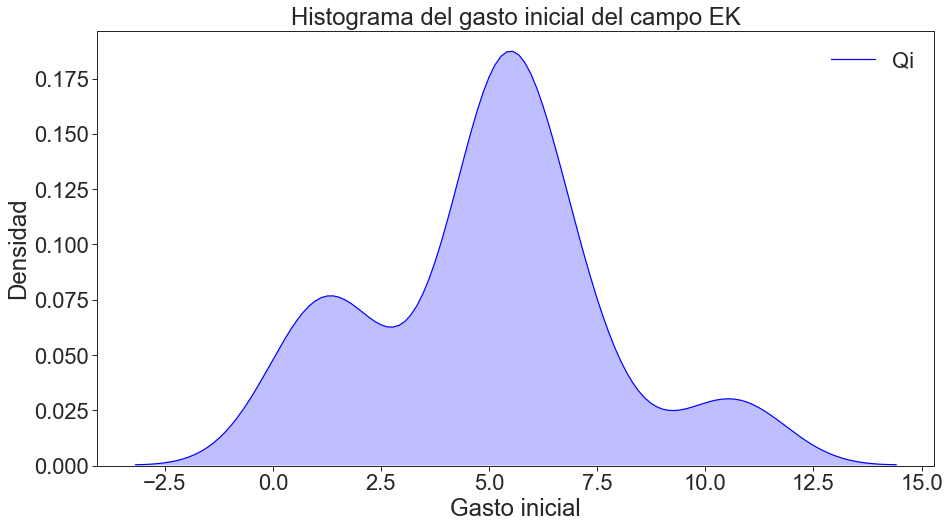

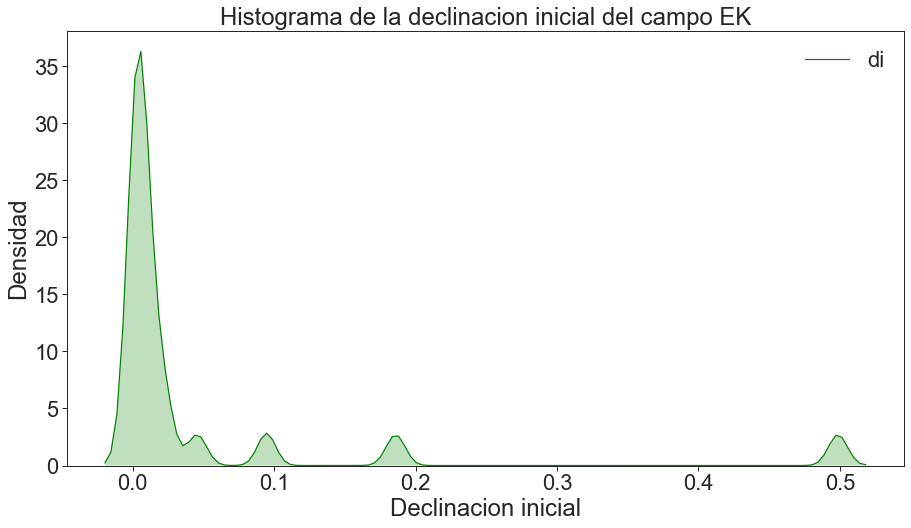

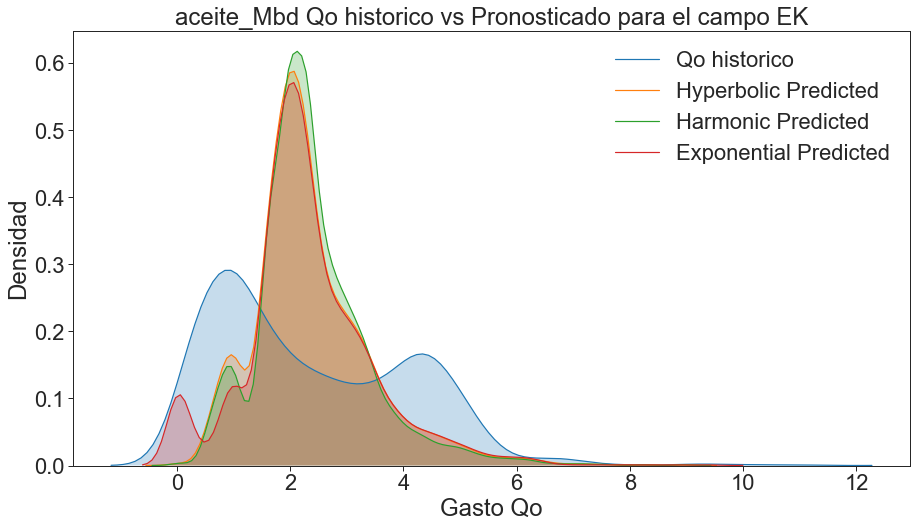

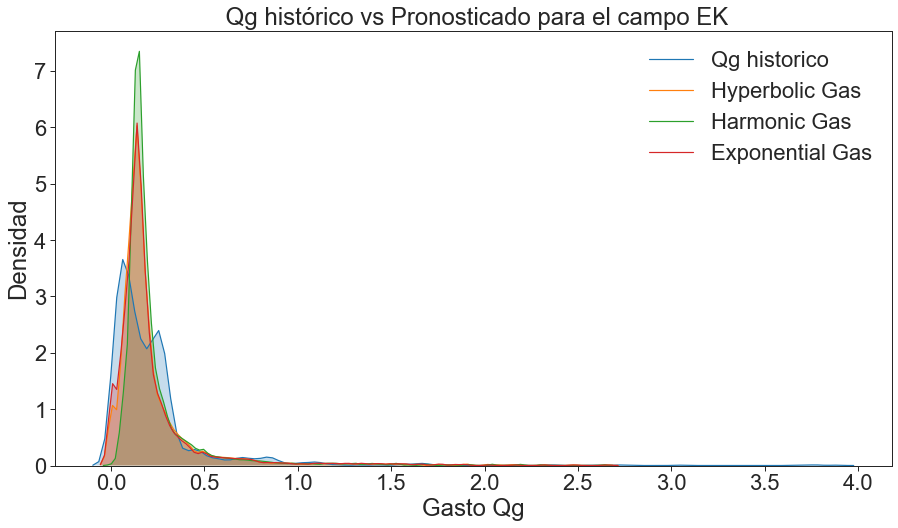

No handles with labels found to put in legend.


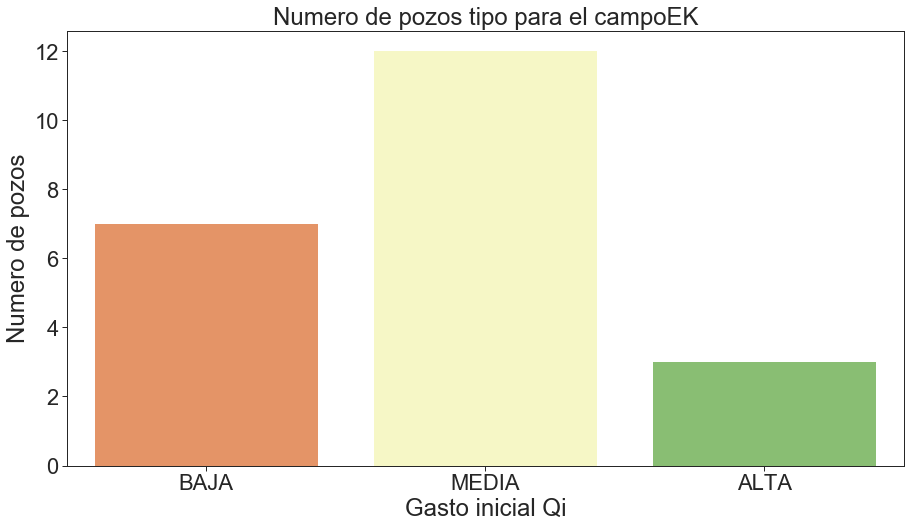

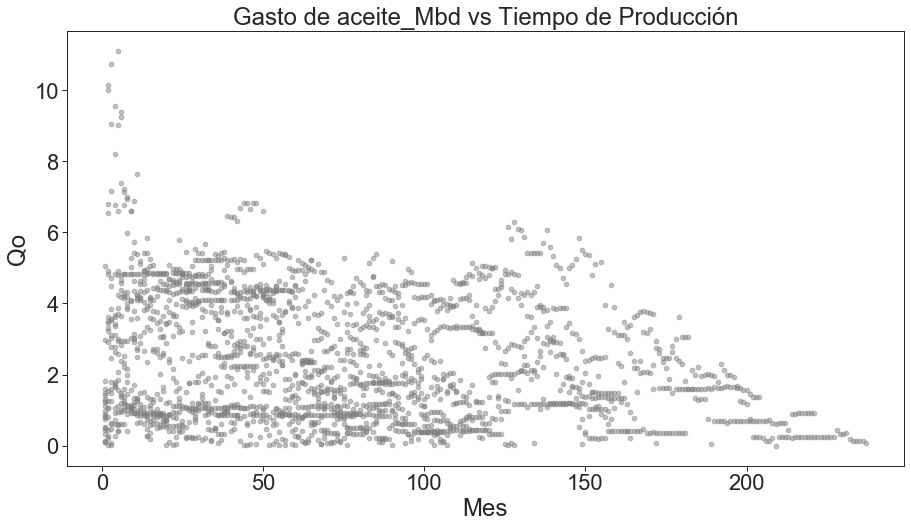

<Figure size 1080x576 with 0 Axes>

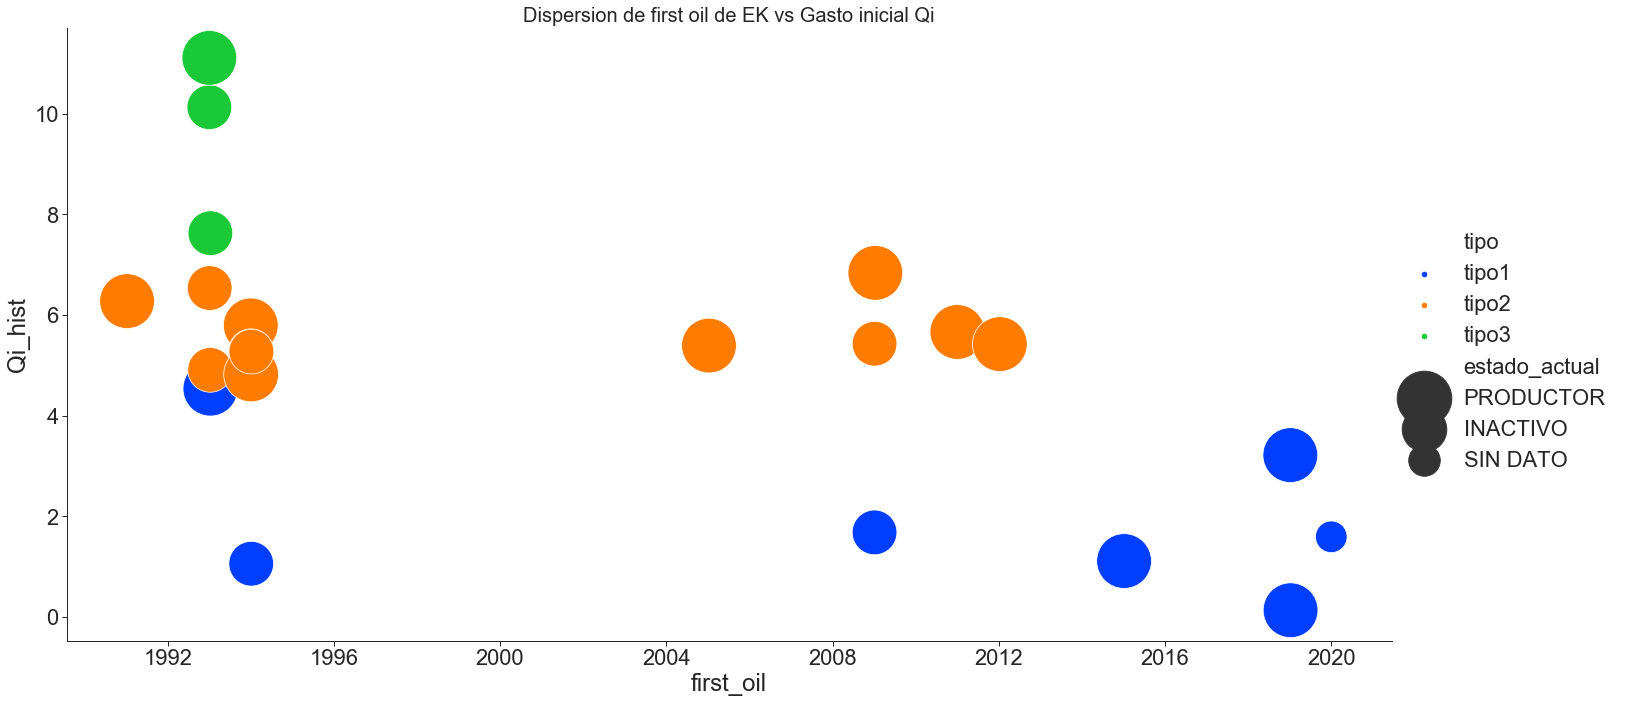

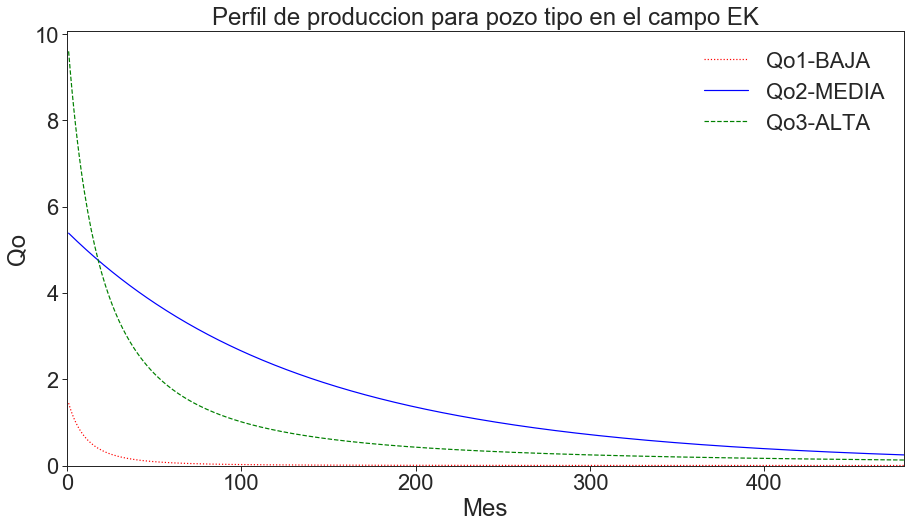

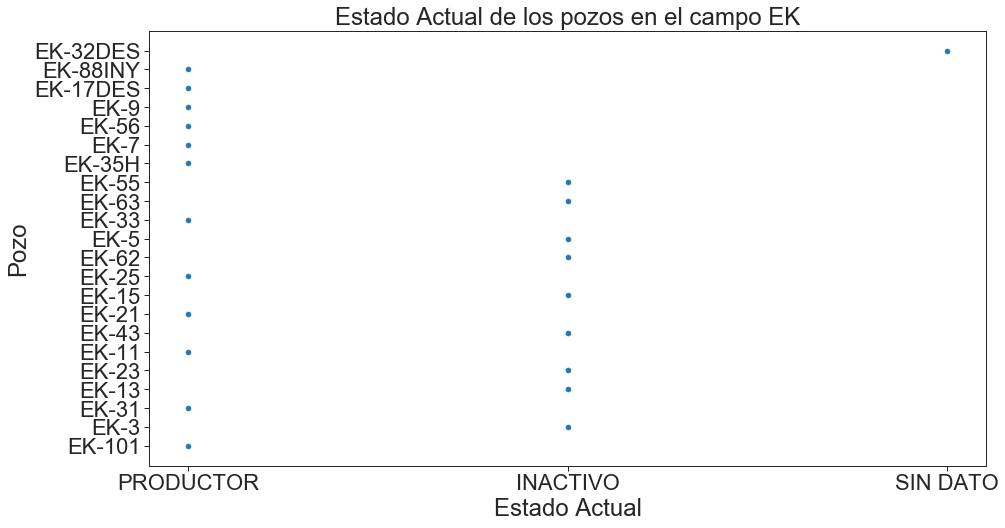

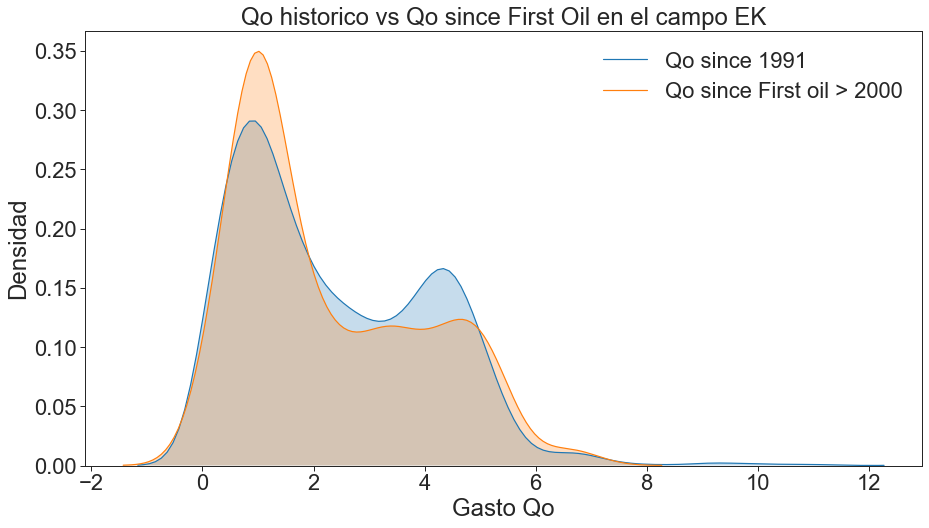

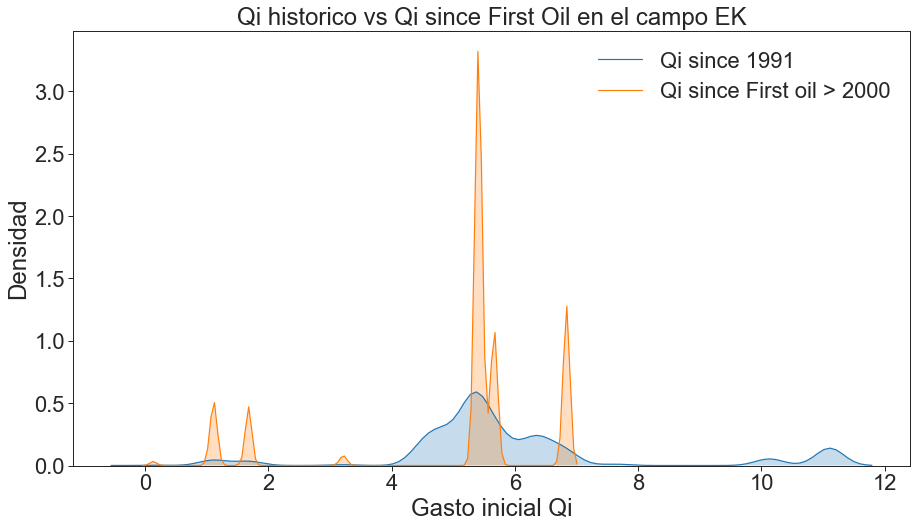

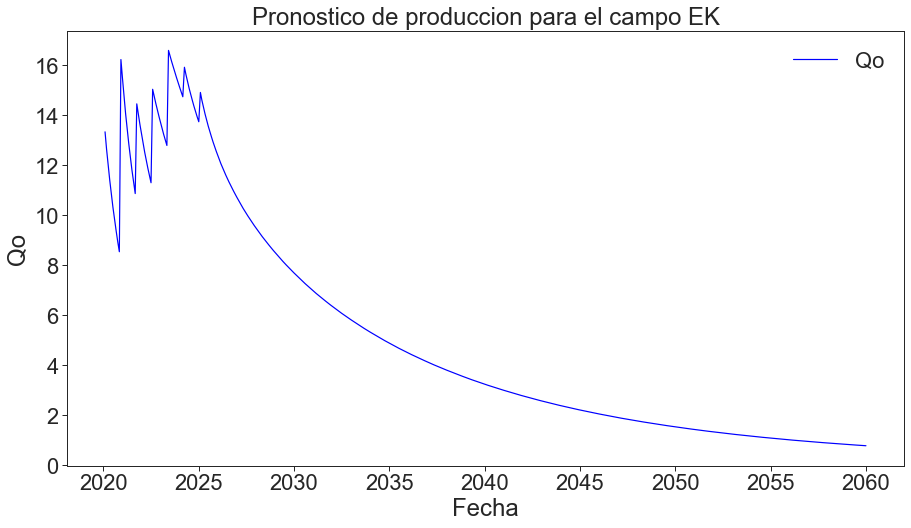

,Qo,Qg,Qc,Capex,Opex,Np,Gp,Cp
count,480.00,480.00,480.00,480.00,480.00,480.00,480.00,480.00
mean,5.09,0.41,0.00,18.62,305.23,"1,784.57",166.74,0.00
std,4.45,0.65,0.00,165.72,255.27,666.71,47.01,0.00
min,0.78,0.01,0.00,0.00,19.89,13.34,1.32,0.00
25%,1.53,0.02,0.00,0.00,99.53,"1,439.81",164.37,0.00
50%,3.23,0.08,0.00,0.00,208.35,"2,041.80",189.06,0.00
75%,7.64,0.46,0.00,0.00,455.01,"2,311.73",194.19,0.00
max,16.59,3.02,0.00,"1,490.00","1,007.93","2,443.91",195.67,0.00


,Proyecto,Estado,CEE
Valor presente neto (VPN),420.40,352.15,68.25
Valor presente de la inversión (VPI),299.13,0.00,299.13
Valor presente de los costos (VPC),"1,147.11",0.00,"1,147.11"
Eficiencia de la inversion (VPN/VPI),1.41,0.00,0.23
Relación beneficio costo (VPN/VPI + VPC),0.29,0.00,0.05
Tasa Interno de Retorno (TIR),nan,0.00,0.15
Participación en el VPN del proyecto,1.00,0.84,0.16
Participación en los FE del proyecto,1.00,0.56,0.44


,Valor
CAPEX (USD/bpce),5.70
Ganancia USD/bpce,9.88
Impuestos (USD/bpce),12.53
Opex (USD/bpce),25.54


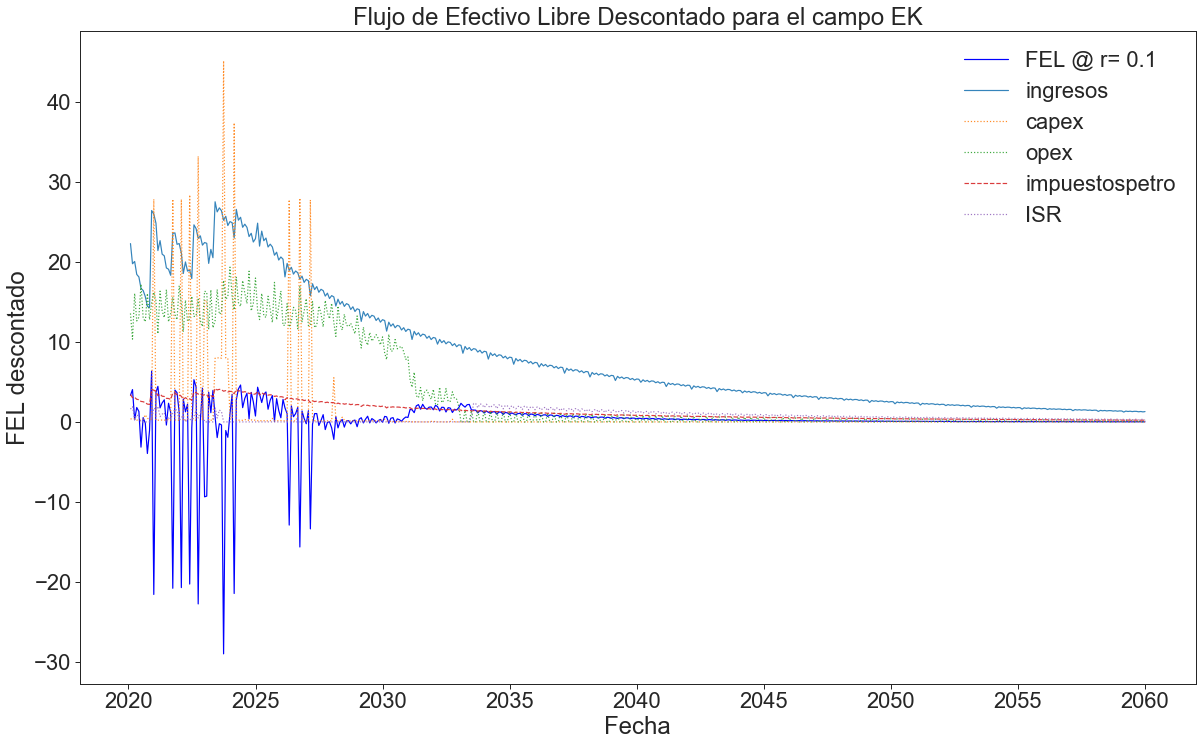

'Tiempo de procesamiento: 31.423963411998557 segundos'

In [244]:
demo()

In [245]:
display(reservas_aceite)

157.7145528

In [246]:
display(info_reservas)

,SUPERFICIE KM2,UBICACION,NOMBRE,TIPO,VO CRUDO 1P (MMB),VO GAS 1P (MMMPC),PETROLEO CRUDO EQUIVALENTE 1P (MMBPCE),CRUDO 1P (MMB),GAS NATURAL 1P (MMBPCE),CONDENSADO 1P (MMB),VO CRUDO 2P (MMB),VO GAS 2P (MMMPC),PETROLEO CRUDO EQUIVALENTE 2P (MMBPCE),CRUDO 2P (MMB),GAS NATURAL 2P (MMBPCE),CONDENSADO 2P (MMB),VO CRUDO 3P (MMB),VO GAS 3P (MMMPC),PETROLEO CRUDO EQUIVALENTE 3P (MMBPCE),CRUDO 3P (MMB),GAS NATURAL 3P (MMBPCE),CONDENSADO 3P (MMB),PRODUCCION ACUMULADA CRUDO (MMB),PRODUCCION ACUMULADA GAS (MMMPC),PETROLEO CRUDO EQUIVALENTE (MMBPCE)
278,16.64,Marino,EK,Campo,"1,017.56",111.34,76.47,74.02,11.34,0.02,"1,017.56",111.34,163.22,157.71,25.42,0.05,"1,017.56",111.34,163.22,157.71,25.42,0.05,170.99,15.69,174.03


In [247]:
display(acumulados)

Np            162.70
Gp             15.21
Cp              0.00
Wp             80.95
OOIP        1,017.56
Fr_aceite       0.16
OGIP          111.34
Fr_gas          0.14
Name: EK, dtype: float64

In [248]:
display(tipos)

,pozo,Qi_hist,Qi_hyp,b,di_hyp,error_Qi_hyp,error_di_hyp,Qi_harm,di_harm,error_Qi_harm,error_di_harm,Qi_exp,di_exp,error_Qi_exp,error_di_exp,aceite_Mbd,mes_max,profundidad_vertical,trayectoria,first_oil,Qi_gas,b_gas,di_gas,Qi_condensado,b_condensado,di_condensado,estado_actual,tipo
0,EK-11,4.54,1.64,0.00,0.00,0.16,0.00,1.64,0.00,0.16,0.00,1.64,0.00,0.16,0.00,aceite_Mbd,204,"4,671.00",DESVIADO,1993-01-11,0.23,1.00,0.01,0.00,0.50,5.00,PRODUCTOR,tipo1
0,EK-62,1.06,1.06,1.00,0.19,2.22,27.95,1.06,0.19,0.79,0.43,0.98,0.12,0.57,0.20,aceite_Mbd,5,"4,769.10",DIRECCIONAL,1994-01-05,0.27,0.06,0.20,0.00,0.50,5.00,INACTIVO,tipo1
0,EK-63,1.68,1.14,0.00,0.00,0.09,0.11,1.13,0.00,0.09,0.00,1.14,0.00,0.09,0.00,aceite_Mbd,42,"4,790.90",DESVIADO,2009-01-04,0.07,0.00,0.00,0.00,0.50,5.00,INACTIVO,tipo1
0,EK-9,1.11,0.91,0.00,0.00,0.08,0.00,0.91,0.00,0.08,0.00,0.91,0.00,0.08,0.00,aceite_Mbd,51,nan,nan,2015-01-06,0.06,0.00,0.00,0.00,0.50,5.00,PRODUCTOR,tipo1
0,EK-17DES,3.21,3.06,1.00,0.01,0.19,145.75,3.06,0.01,0.10,0.01,3.06,0.01,0.09,0.01,aceite_Mbd,8,nan,HORIZONTAL,2019-01-06,0.51,1.00,0.01,0.00,0.50,5.00,PRODUCTOR,tipo1
0,EK-88INY,0.13,0.13,0.00,0.50,inf,inf,0.13,0.74,0.46,4.83,0.13,0.50,0.20,0.95,aceite_Mbd,3,nan,nan,2019-01-08,0.02,0.00,0.50,0.00,0.50,5.00,PRODUCTOR,tipo1
0,EK-32DES,1.59,1.59,0.43,0.00,inf,inf,1.59,0.00,inf,inf,1.59,0.00,inf,inf,aceite_Mbd,1,"4,228.00",DIRECCIONAL J,2020-01-01,0.26,0.99,0.00,0.00,0.50,5.00,SIN DATO,tipo1
0,EK-101,6.27,1.96,1.00,0.00,0.25,0.00,1.96,0.00,0.25,0.00,1.96,0.00,0.25,0.00,aceite_Mbd,221,"4,607.00",VERTICAL,1991-01-10,0.21,0.00,0.00,0.00,0.50,5.00,PRODUCTOR,tipo2
0,EK-13,6.53,5.15,0.00,0.01,0.24,0.00,5.11,0.01,0.39,0.00,5.15,0.01,0.31,0.00,aceite_Mbd,118,"4,320.20",DESVIADO,1993-01-05,2.28,0.55,0.10,0.00,0.50,5.00,INACTIVO,tipo2
0,EK-23,4.91,3.50,0.00,0.01,0.30,0.28,3.50,0.01,0.35,0.00,3.50,0.01,0.29,0.00,aceite_Mbd,106,"4,500.00",VERTICAL,1993-01-09,1.01,0.19,0.04,0.00,0.50,5.00,INACTIVO,tipo2


In [249]:
display(perfil.head())
display(gasto.head())

,fecha,tipo1_baja,tipo2_media,tipo3_alta
mes,,,,
1,2020-01-31,1.44,5.38,9.60
2,2020-02-29,1.31,5.34,9.11
3,2020-03-31,1.20,5.31,8.67
4,2020-04-30,1.10,5.27,8.26
5,2020-05-31,1.01,5.23,7.88


,pozo,Qi_hist,Qi_hyp,b,di_hyp,error_Qi_hyp,error_di_hyp,Qi_harm,di_harm,error_Qi_harm,error_di_harm,Qi_exp,di_exp,error_Qi_exp,error_di_exp,aceite_Mbd,mes_max,profundidad_vertical,trayectoria,first_oil,Qi_gas,b_gas,di_gas,Qi_condensado,b_condensado,di_condensado,estado_actual
0,EK-101,6.27,1.96,1.00,0.00,0.25,0.00,1.96,0.00,0.25,0.00,1.96,0.00,0.25,0.00,aceite_Mbd,221,"4,607.00",VERTICAL,1991-01-10,0.21,0.00,0.00,0.00,0.50,5.00,PRODUCTOR
0,EK-3,10.13,7.74,1.00,0.05,1.12,0.74,7.74,0.05,0.81,0.01,6.50,0.02,0.53,0.00,aceite_Mbd,69,"4,388.60",DESVIADO,1993-01-02,2.27,0.67,0.06,0.00,0.50,5.00,INACTIVO
0,EK-31,11.11,9.80,1.00,0.09,1.49,0.25,9.80,0.09,1.16,0.02,9.98,0.06,0.99,0.01,aceite_Mbd,181,"4,755.60",DESVIADO,1993-01-02,2.84,0.00,0.07,0.00,0.50,5.00,PRODUCTOR
0,EK-13,6.53,5.15,0.00,0.01,0.24,0.00,5.11,0.01,0.39,0.00,5.15,0.01,0.31,0.00,aceite_Mbd,118,"4,320.20",DESVIADO,1993-01-05,2.28,0.55,0.10,0.00,0.50,5.00,INACTIVO
0,EK-23,4.91,3.50,0.00,0.01,0.30,0.28,3.50,0.01,0.35,0.00,3.50,0.01,0.29,0.00,aceite_Mbd,106,"4,500.00",VERTICAL,1993-01-09,1.01,0.19,0.04,0.00,0.50,5.00,INACTIVO


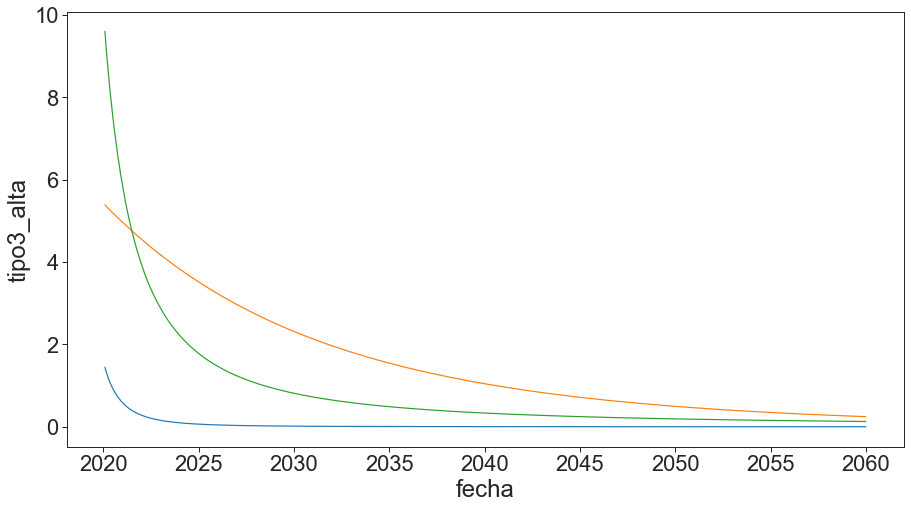

In [252]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='fecha', y="tipo1_baja", data=perfil,estimator='mean',err_style='band',ci=90)
ax = sns.lineplot(x='fecha', y="tipo2_media", data=perfil,estimator='mean',err_style='band',ci=90)
ax = sns.lineplot(x='fecha', y="tipo3_alta", data=perfil, estimator='mean',err_style='band',ci=90)